In [1]:
import pandas as pd
import numpy as np
import sqlite3
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
EXPERIMENT_NAME = 'P3856'

#### prepare the TFD/E results

In [3]:
# load the results
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/{}'.format(EXPERIMENT_NAME)
RESULTS_DB_NAME = '{}/summarised-results/results.sqlite'.format(EXPERIMENT_DIR)
db_conn = sqlite3.connect(RESULTS_DB_NAME)
results_df = pd.read_sql_query("select * from sequences", db_conn)
db_conn.close()

In [4]:
len(results_df)

23295

In [5]:
# convert the identifications from JSON to Python objects
results_df['identifications_d'] = results_df.apply(lambda row: json.loads(row.identifications), axis=1)

In [6]:
def classify_protein(protein):
    result = 'UNKNOWN'
    if 'HUMAN' in protein.upper():
        result = 'HUMAN'
    elif 'YEAST' in protein.upper():
        result = 'YEAST'
    elif 'ECOLI' in protein.upper():
        result = 'E.COLI'
    return result

In [7]:
# separate some key metrics into separate columns
results_df['id_perc_q_value'] = results_df.apply(lambda row: row.identifications_d['perc_q_value'], axis=1)
results_df['id_count_all_runs'] = results_df.apply(lambda row: len(row.identifications_d['run_names']), axis=1)
results_df['id_count_human_only_runs'] = results_df.apply(lambda row: sum('YHE010' in s for s in row.identifications_d['run_names']), axis=1)
results_df['id_number_of_proteins'] = results_df.apply(lambda row: row.identifications_d['number_of_proteins'], axis=1)

In [8]:
results_df['id_protein'] = results_df.apply(lambda row: row.identifications_d['proteins'][0], axis=1)
results_df['id_species'] = results_df.apply(lambda row: classify_protein(row.id_protein), axis=1)

In [9]:
results_df.id_species.unique()

array(['HUMAN', 'E.COLI', 'YEAST'], dtype=object)

In [10]:
# remove the results that couldn't be extracted or were not classified as a target
results_df = results_df[results_df.extractions.notnull()].copy()

In [11]:
# convert from JSON to Python objects
results_df['extractions_l'] = results_df.apply(lambda row: json.loads(row.extractions), axis=1)

In [12]:
# separate some key metrics into separate columns
results_df['ext_count_all_runs'] = results_df.apply(lambda row: len(row.extractions_l), axis=1)
results_df['ext_count_human_only_runs'] = results_df.apply(lambda row: sum('YHE010' in s['run_name'] for s in row.extractions_l), axis=1)

In [13]:
results_df.sample(n=3)

,sequence,charge,identifications,extractions,identifications_d,id_perc_q_value,id_count_all_runs,id_count_human_only_runs,id_number_of_proteins,id_protein,id_species,extractions_l,ext_count_all_runs,ext_count_human_only_runs
14830,NQLSTLPEELGDLPLVR,2,"{""perc_q_value"": 3.817231e-06, ""run_names"": [""...","[{""run_name"": ""P3856_YHE211_6_Slot1-1_1_5109"",...","{'perc_q_value': 3.817231e-06, 'run_names': ['...",0.000004,1,1,1,sp|O75427|LRCH4_HUMAN,HUMAN,"[{'run_name': 'P3856_YHE211_6_Slot1-1_1_5109',...",21,9
9327,IGGTHSGLTPQSSISSDK,2,"{""perc_q_value"": 8.663968e-05, ""run_names"": [""...","[{""run_name"": ""P3856_YHE211_6_Slot1-1_1_5109"",...","{'perc_q_value': 8.663968e-05, 'run_names': ['...",0.000087,3,0,1,sp|Q04336|YM54_YEAST,YEAST,"[{'run_name': 'P3856_YHE211_6_Slot1-1_1_5109',...",29,10
5203,ETDYPAGEDLSESGQVDK,2,"{""perc_q_value"": 3.817231e-06, ""run_names"": [""...","[{""run_name"": ""P3856_YHE211_6_Slot1-1_1_5109"",...","{'perc_q_value': 3.817231e-06, 'run_names': ['...",0.000004,16,10,1,sp|O60271|JIP4_HUMAN,HUMAN,"[{'run_name': 'P3856_YHE211_6_Slot1-1_1_5109',...",30,10


In [14]:
results_df.iloc[0].identifications

'{"perc_q_value": 6.2318886e-06, "run_names": ["P3856_YHE211_2_Slot1-1_1_5105", "P3856_YHE211_4_Slot1-1_1_5107"], "number_of_runs": 2, "proteins": ["sp|Q9P258|RCC2_HUMAN"], "number_of_proteins": 1}'

In [15]:
# count the number of unique peptide identifications in each run
counts_d = {}
for row in results_df.itertuples():
    for run_name in row.identifications_d['run_names']:
        if run_name not in counts_d:
            counts_d[run_name] = 0
        counts_d[run_name] += 1

In [16]:
# sort the run names by group then run number within the group
sorted_counts_l = []
for k in sorted(list(counts_d.keys()), key=lambda x: ( x.split('_')[1], int(x.split('_')[2]) )):
    short_run_name = '_'.join(k.split('_Slot')[0].split('_')[1:])
    sorted_counts_l.append((short_run_name, counts_d[k]))
sorted_counts_df = pd.DataFrame(sorted_counts_l, columns=['run_name','count'])

#### prepare the MaxQuant results

In [17]:
mq_results_df = pd.read_csv('{}/evidence-P3856.txt'.format(EXPERIMENT_DIR), sep='\\t', engine='python')

In [18]:
# remove decoys, which are indicated by a '+' in the Reverse column
mq_results_df = mq_results_df[pd.isna(mq_results_df.Reverse)]
# remove identifications with no intensity
mq_results_df = mq_results_df[(mq_results_df.Intensity > 0)]
# remove potential contaminants
mq_results_df = mq_results_df[pd.isna(mq_results_df['Potential contaminant'])]
# remove identifications with mass error more than +/- 5 ppm
mq_results_df = mq_results_df[np.abs(mq_results_df['Mass error [ppm]']) <= 5.0]

In [19]:
# definition of uniqueness in MaxQuant output with MBR on
unique_peptide_key = ['Sequence','Modifications','Charge']

In [20]:
# count the number of unique peptide identifications in each run
mq_counts_d = {}
for group_name,group_df in mq_results_df.groupby(unique_peptide_key, as_index=False):
    df = group_df[(group_df.Type == 'TIMS-MULTI-MSMS')]
    for run_name in df['Raw file'].unique():
        if run_name not in mq_counts_d:
            mq_counts_d[run_name] = 0
        mq_counts_d[run_name] += 1

In [21]:
mq_sorted_counts_l = []
for k in sorted(mq_counts_d.keys()):
    short_run_name = '_'.join(k.split('_Slot')[0].split('_')[1:3])
    mq_sorted_counts_l.append((short_run_name, mq_counts_d[k]))
mq_sorted_counts_df = pd.DataFrame(mq_sorted_counts_l, columns=['run_name','count'])

#### prepare the MSFragger results

In [22]:
# use the Fragger analysis without MBR because there doesn't seem to be a way of distinguishing between identification and matching
fragger_results_df = pd.read_csv('{}/MSstats-without-MBR.csv'.format(EXPERIMENT_DIR), sep=',')


In [23]:
fragger_results_df = fragger_results_df[fragger_results_df.Intensity.notnull()]

In [24]:
fragger_results_df.sample(n=5)

,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity
546617,sp|Q92598|HS105_HUMAN,LMSSNSTDLPLNIEC[57.0215]FMNDK,2,NaN,NaN,L,YHE114,7,P3856_YHE114_7_Slot1-1_1_5121,70417.640
138432,sp|P0DN79|CBSL_HUMAN,VQELGLSAPLTVLPTITC[57.0215]GHTIEILR,3,NaN,NaN,L,YHE114,2,P3856_YHE114_2_Slot1-1_1_5116,137588.060
467287,sp|Q15154|PCM1_HUMAN,ESPPTVDSTQQPNPLPLR,2,NaN,NaN,L,YHE010,7,P3856_YHE010_7_Slot1-1_1_5099,38576.920
347530,sp|P54727|RD23B_HUMAN,QIIQQNPSLLPALLQQIGR,2,NaN,NaN,L,YHE114,10,P3856_YHE114_10_Slot1-1_1_5124,172294.360
210459,sp|P25786|PSA1_HUMAN,FVFDRPLPVSR,2,NaN,NaN,L,YHE010,9,P3856_YHE010_9_Slot1-1_1_5101,30863.889


In [25]:
# count the number of unique peptide identifications in each run
fragger_counts_d = {}
for group_name,group_df in fragger_results_df.groupby(['PeptideSequence', 'PrecursorCharge'], as_index=False):
    for run_name in group_df['Run'].unique():
        if run_name not in fragger_counts_d:
            fragger_counts_d[run_name] = 0
        fragger_counts_d[run_name] += 1

In [26]:
# sort the run names by group then run number within the group
sorted_counts_l = []
for k in sorted(list(fragger_counts_d.keys()), key=lambda x: ( x.split('_')[1], int(x.split('_')[2]) )):
    short_run_name = '_'.join(k.split('_Slot')[0].split('_')[1:])
    sorted_counts_l.append((short_run_name, fragger_counts_d[k]))
fragger_sorted_counts_df = pd.DataFrame(sorted_counts_l, columns=['run_name','count'])

#### plot the unique peptide level

In [27]:
merged_df = sorted_counts_df.merge(mq_sorted_counts_df,on='run_name').merge(fragger_sorted_counts_df,on='run_name')
merged_df.rename({'count_x':'count_tfd/e', 'count_y':'count_mq', 'count':'count_fragger'}, axis=1, inplace=True)
merged_df.index = merged_df.run_name

In [28]:
merged_df.sample(n=3)

,run_name,count_tfd/e,count_mq,count_fragger
run_name,,,,
YHE211_5,YHE211_5,9502,10146,12836
YHE114_1,YHE114_1,8976,9366,12140
YHE211_10,YHE211_10,8670,9285,11987


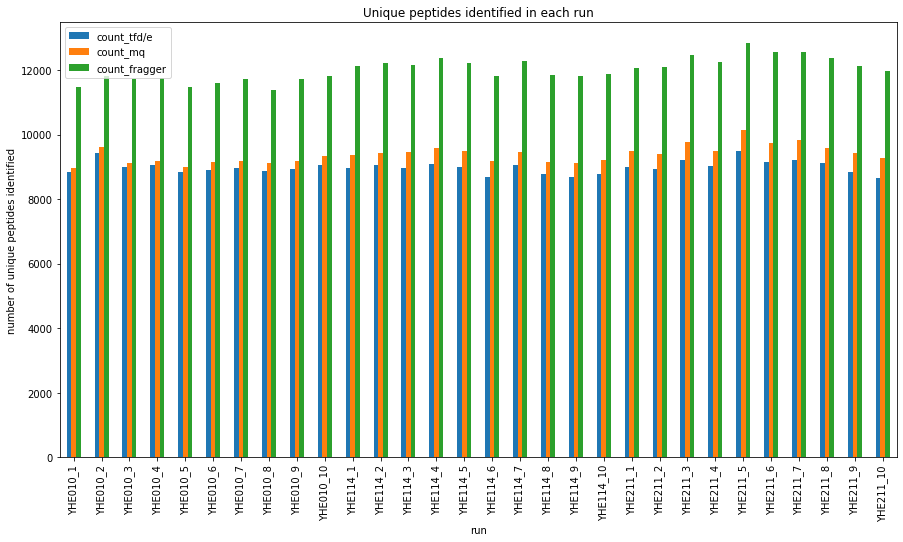

In [29]:
merged_df.plot(kind='bar', figsize=(15,8))
_ = plt.title("Unique peptides identified in each run")
_ = plt.xlabel("run")
_ = plt.ylabel("number of unique peptides identified")

## missing-ness heatmaps

In [30]:
# return True if we can include an extraction from the specified group, given the groups in which it was identified
# need to implement these rules differently for each experiment, probably best with a simple rules parameter file
def extract_from_group(extract_group, identification_run_names_l):
    result = False
    identification_groups_l = list(set([r.split('_')[1] for r in identification_run_names_l]))
    if extract_group == 'YHE010':
        result = extract_group in identification_groups_l
    else:
        result = True
    return result

#### prepare the TFD/E data

In [31]:
# gather the lower intensity decile
results_df.columns

Index(['sequence', 'charge', 'identifications', 'extractions',
       'identifications_d', 'id_perc_q_value', 'id_count_all_runs',
       'id_count_human_only_runs', 'id_number_of_proteins', 'id_protein',
       'id_species', 'extractions_l', 'ext_count_all_runs',
       'ext_count_human_only_runs'],
      dtype='object')

In [32]:
results_df.iloc[0].extractions_l

[{'run_name': 'P3856_YHE211_6_Slot1-1_1_5109',
  'prob_target': 0.9969171051130503,
  'intensity': 634,
  'inferred': 0},
 {'run_name': 'P3856_YHE211_10_Slot1-1_1_5113',
  'prob_target': 0.9907430892610842,
  'intensity': 605,
  'inferred': 0},
 {'run_name': 'P3856_YHE010_9_Slot1-1_1_5101',
  'prob_target': 0.9981337828837087,
  'intensity': 917,
  'inferred': 0},
 {'run_name': 'P3856_YHE211_8_Slot1-1_1_5111',
  'prob_target': 0.9932252590861345,
  'intensity': 1096,
  'inferred': 0},
 {'run_name': 'P3856_YHE114_2_Slot1-1_1_5116',
  'prob_target': 0.9990767933834946,
  'intensity': 778,
  'inferred': 0},
 {'run_name': 'P3856_YHE114_10_Slot1-1_1_5124',
  'prob_target': 0.9090683896187263,
  'intensity': 395,
  'inferred': 0},
 {'run_name': 'P3856_YHE010_1_Slot1-1_1_5093',
  'prob_target': 0.9628500280416097,
  'intensity': 574,
  'inferred': 0},
 {'run_name': 'P3856_YHE114_6_Slot1-1_1_5120',
  'prob_target': 0.9412491239900864,
  'intensity': 596,
  'inferred': 0},
 {'run_name': 'P3856_

In [33]:
sequences_l = []
for row in results_df.itertuples():
    for group_name in ['YHE114','YHE211','YHE010']:
        if extract_from_group(extract_group=group_name, identification_run_names_l=row.identifications_d['run_names']):
            for extraction in row.extractions_l:
                if group_name in extraction['run_name']:
                    short_run_name = '_'.join(extraction['run_name'].split('_Slot')[0].split('_')[1:3])
                    identified_in_run = extraction['run_name'] in row.identifications_d['run_names']
                    sequences_l.append((row.sequence, row.charge, row.id_perc_q_value, row.id_protein, row.id_species, short_run_name, group_name, extraction['intensity'], identified_in_run))
sequences_df = pd.DataFrame(sequences_l, columns=['sequence', 'charge', 'id_perc_q_value', 'protein', 'species', 'short_run_name', 'group','intensity','identified_in_run'])


In [34]:
sequences_df[sequences_df.species == 'E.COLI'].sample(n=5)

,sequence,charge,id_perc_q_value,protein,species,short_run_name,group,intensity,identified_in_run
167647,GHGIAQDLM[15.9949]PRLDVDAAGVASVVEEPTLTPHQFPR,3,0.007967,sp|P08394|RECB_ECOLI,E.COLI,YHE114_9,YHE114,535,False
196620,HIAMHVAASKPEFIKPEDVSAEVVEK,4,0.000004,sp|P0A6P1|EFTS_ECOLI,E.COLI,YHE211_5,YHE211,373,False
410008,SEFAENDAYVHATPLIR,2,0.000004,sp|P06959|ODP2_ECOLI,E.COLI,YHE211_1,YHE211,375,False
100182,EGDPNDFADIPTLLSGLVAK,2,0.000004,sp|P56262|DLHH_ECOLI,E.COLI,YHE211_4,YHE211,332,False
198133,HIVMHNEQAVISPSWSIHSGVGTK,3,0.000004,sp|Q46938|KDUI_ECOLI,E.COLI,YHE114_8,YHE114,1784,True


In [35]:
# find the mean intensity for each peptide in each group
intensities_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge','group'], as_index=False):
    mean_intensity = group_df.intensity.mean()
    intensities_l.append((group_name[0], group_name[1], group_name[2], mean_intensity))
intensities_df = pd.DataFrame(intensities_l, columns=['sequence', 'charge', 'group', 'group_mean_intensity'])

In [36]:
# sort each group by descending intensity
intensities_df.sort_values(by=['group_mean_intensity'], ascending=False, inplace=True)

In [37]:
intensities_df.tail()

,sequence,charge,group,group_mean_intensity
5378,CQEVISWLDANTLAEK,3,YHE114,45.5
24347,IHEGCEEPATHNALAK,3,YHE114,44.0
56903,VVTM[15.9949]NDNSDEYFQIQHYLK,3,YHE211,28.0
24599,IIQIDINPASIGAHSK,2,YHE114,27.0
4128,ATNVTYQAHHVSR,2,YHE114,10.0


In [38]:
# make a separate DF for each group
yhe010_df = intensities_df[(intensities_df.group == 'YHE010')].copy()
yhe114_df = intensities_df[(intensities_df.group == 'YHE114')].copy()
yhe211_df = intensities_df[(intensities_df.group == 'YHE211')].copy()

In [39]:
# find the lowest-intensity peptides in each group
lower_proportion = 0.1
yhe010_lowest_df = yhe010_df.tail(int(lower_proportion * len(yhe010_df)))
yhe114_lowest_df = yhe114_df.tail(int(lower_proportion * len(yhe114_df)))
yhe211_lowest_df = yhe211_df.tail(int(lower_proportion * len(yhe211_df)))

## TFD/E heatmaps

#### plot YHE010

In [40]:
run_names_l = sorted(list(sequences_df[sequences_df.group == 'YHE010'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [41]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe010_lowest_df.itertuples():
    run_occurences_df = sequences_df[(sequences_df.sequence == row.sequence) & (sequences_df.charge == row.charge) & (sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

In [42]:
occurences_df.head()

,YHE010_1,YHE010_2,YHE010_3,YHE010_4,YHE010_5,YHE010_6,YHE010_7,YHE010_8,YHE010_9,YHE010_10
"EMPPVDPNILDYIQPSTQDR,2",9.177420,7.285402,8.459432,9.705632,8.900867,7.942515,8.519636,8.550747,8.447083,8.515700
"EEPVSEEGEEDEEQEAEEEPMDTSPSGLHSK,3",0.000000,9.014020,8.921841,0.000000,8.915879,8.820179,8.554589,8.321928,8.219169,8.455327
"HYLPLSSILDTLDVMAYNK,3",8.826548,8.751544,8.339850,8.861087,8.741467,8.511753,8.781360,8.103288,8.618386,9.030667
"EGSLPGTSVPPSMDAGR,2",8.787903,8.169925,8.632995,9.090112,8.426265,8.483816,8.144658,9.095397,8.804131,8.800900
"QDDPFELFIAATNIR,2",8.882643,8.566054,8.622052,9.204571,7.864186,8.422065,8.442943,8.569856,8.864186,8.936638


Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE010')

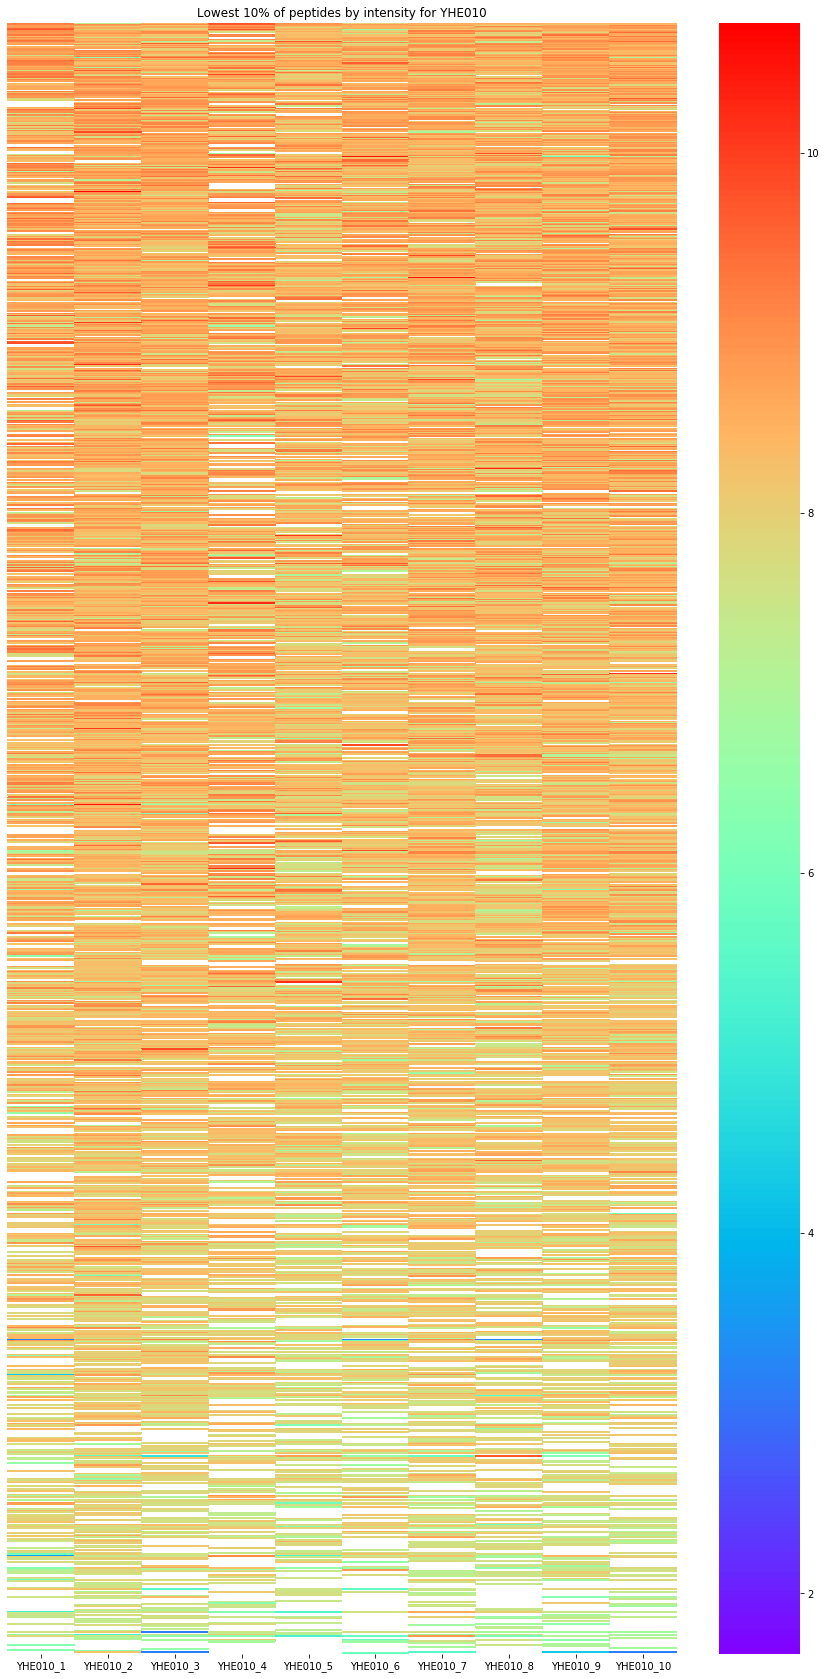

In [43]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE010'.format(int(lower_proportion*100)))

#### plot YHE114

In [44]:
run_names_l = sorted(list(sequences_df[sequences_df.group == 'YHE114'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [45]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe114_lowest_df.itertuples():
    run_occurences_df = sequences_df[(sequences_df.sequence == row.sequence) & (sequences_df.charge == row.charge) & (sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE114')

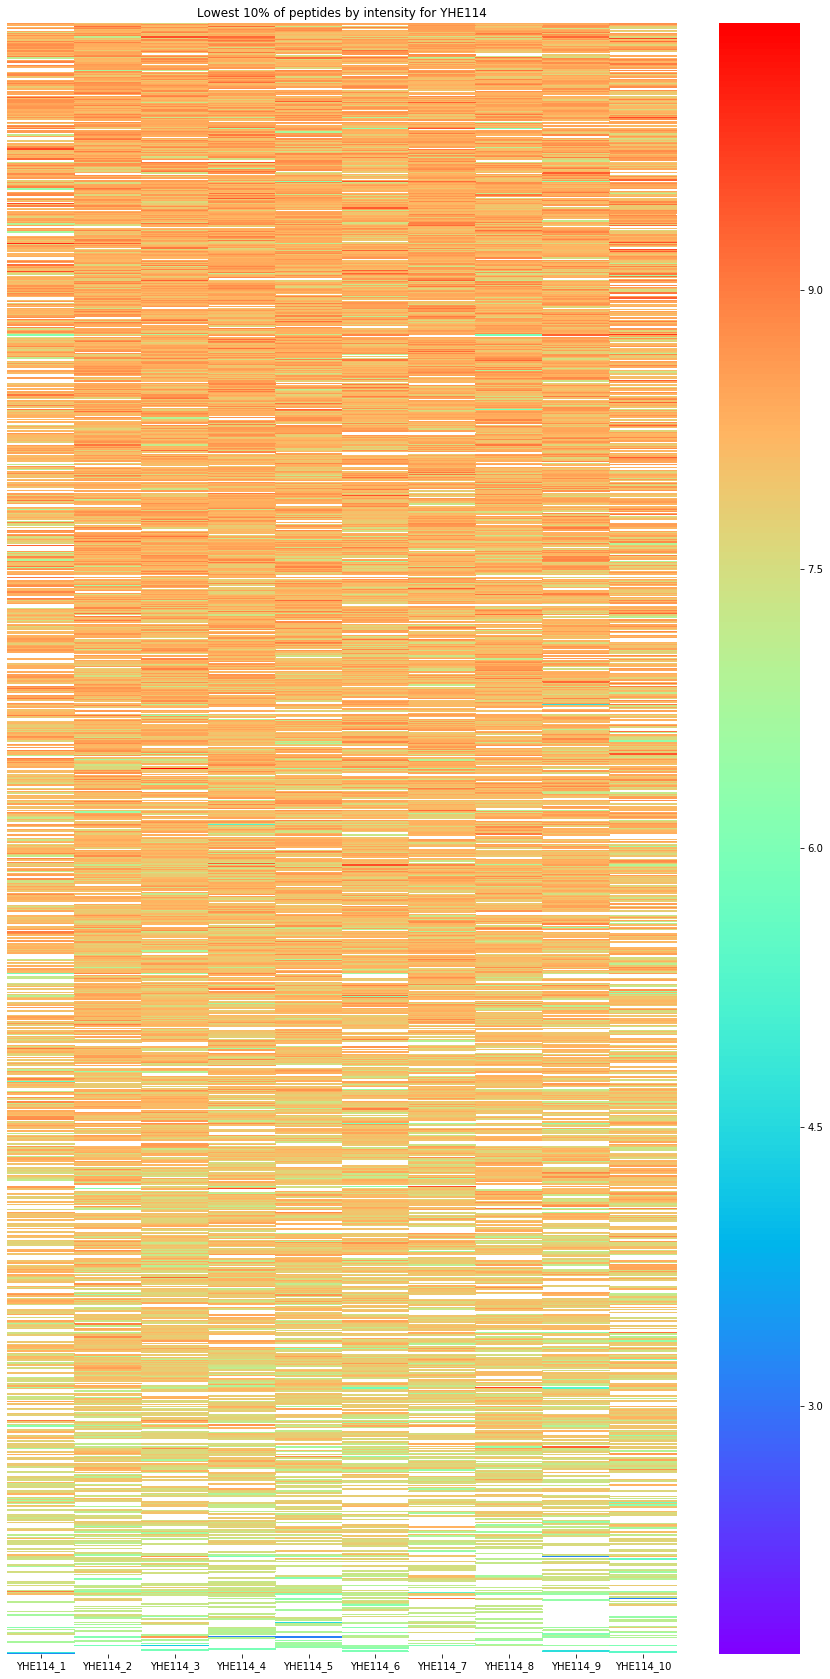

In [46]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE114'.format(int(lower_proportion*100)))

#### plot YHE211

In [47]:
run_names_l = sorted(list(sequences_df[sequences_df.group == 'YHE211'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [48]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe211_lowest_df.itertuples():
    run_occurences_df = sequences_df[(sequences_df.sequence == row.sequence) & (sequences_df.charge == row.charge) & (sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE211')

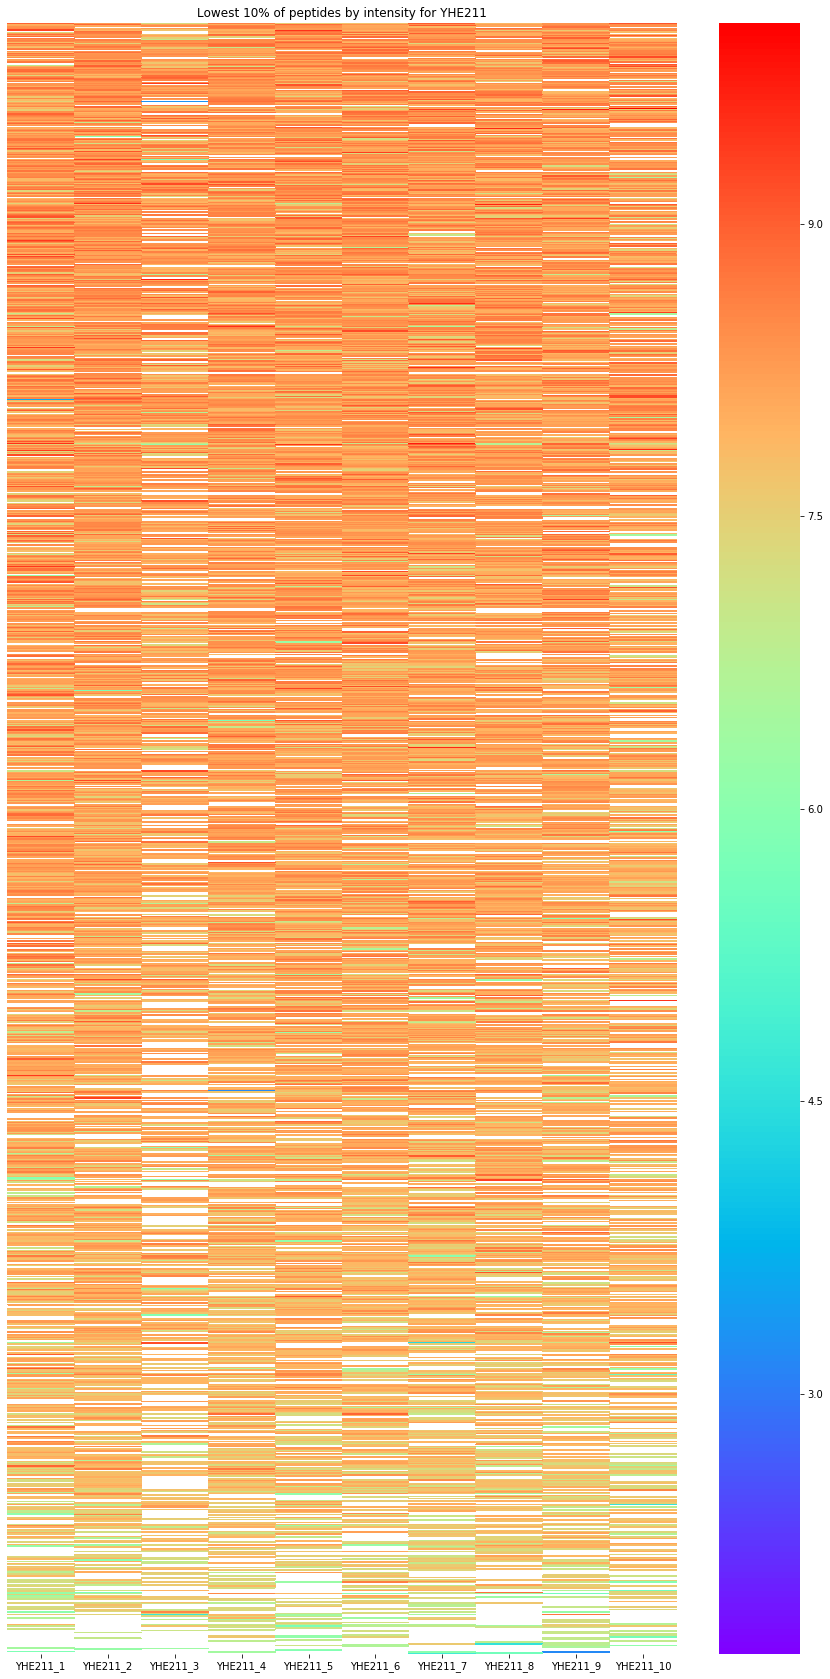

In [49]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE211'.format(int(lower_proportion*100)))

## MaxQuant heatmaps

In [50]:
mq_results_df.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Type',
       'Raw file', 'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'Calibrated CCS', 'CCS length', 'Match time difference',
       'Match m/z difference', 'Match K0 difference', 'Match q-value',
       'M

In [51]:
mq_results_df.iloc[1466].Proteins

'sp|P31040|SDHA_HUMAN'

In [52]:
# get one reading for each unique peptide in each run, and count how many identifications and extractions (i.e. 
# matches) across each group. Note that a sequence can be counted as an identification and a match in the same file 
# (i.e. it's given a different score).
mq_sequences_l = []
unique_peptide_key_file = unique_peptide_key + ['Raw file']
for group_name,group_df in mq_results_df.groupby(unique_peptide_key_file, as_index=False):
    identified_in_file = (len(group_df[group_df.Type == 'TIMS-MULTI-MSMS']) > 0)
    short_run_name = '_'.join(group_name[3].split('_Slot')[0].split('_')[1:3])
    grp_name = short_run_name.split('_')[0]
    sorted_df = group_df.sort_values(by=['Intensity'], ascending=False, inplace=False)
    if identified_in_file:
        score = sorted_df.iloc[0]['Score']
    else:
        score = sorted_df.iloc[0]['Match score']
    intensity = sorted_df.iloc[0].Intensity
    protein = sorted_df.iloc[0].Proteins
    species = classify_protein(protein)
    mq_sequences_l.append((group_name[0], group_name[1], group_name[2], species, short_run_name, grp_name, identified_in_file, score, intensity))
mq_sequences_df = pd.DataFrame(mq_sequences_l, columns=['sequence','modifications','charge','species','short_run_name','group','identified_in_file','score','intensity'])


In [53]:
mq_sequences_df.sample(n=5)

,sequence,modifications,charge,species,short_run_name,group,identified_in_file,score,intensity
168787,ILATGANVILTTGGIDDMCLK,Unmodified,2,HUMAN,YHE114_1,YHE114,True,164.22,403290.0
243483,MLLNDFLNDQNR,Unmodified,2,HUMAN,YHE211_4,YHE211,True,183.00,51188.0
279516,PSILTYQYAEDLIR,Unmodified,2,HUMAN,YHE114_10,YHE114,False,151.55,20353.0
136504,GTRDDEYDYLFK,Acetyl (Protein N-term),2,HUMAN,YHE010_2,YHE010,True,112.70,440710.0
134236,GSGNLEAIHIIK,Unmodified,2,HUMAN,YHE010_4,YHE010,True,195.80,162090.0


In [54]:
# find the mean intensity for each peptide in each group
mq_intensities_l = []
for group_name,group_df in mq_sequences_df.groupby(['sequence','modifications','charge','group'], as_index=False):
    mean_intensity = group_df.intensity.mean()
    mq_intensities_l.append((group_name[0], group_name[1], group_name[2], group_name[3], mean_intensity))
mq_intensities_df = pd.DataFrame(mq_intensities_l, columns=['sequence', 'modifications', 'charge', 'group', 'group_mean_intensity'])

In [55]:
# sort each group by descending intensity
mq_intensities_df.sort_values(by=['group_mean_intensity'], ascending=False, inplace=True)

In [56]:
mq_intensities_df.tail()

,sequence,modifications,charge,group,group_mean_intensity
46385,VDNAYWLWTFQGR,Unmodified,2,YHE114,873.45
34372,NYLPLLEPVKPEPK,Unmodified,2,YHE211,869.28
8699,EATWTMSNITAGR,Unmodified,2,YHE010,756.94
3300,AQLAQDGVQLCALDDLDSK,Unmodified,2,YHE114,728.88
27256,LMAPYTPFLTELMYQNLK,Unmodified,2,YHE010,719.49


In [57]:
# make a separate DF for each group
yhe010_df = mq_intensities_df[(mq_intensities_df.group == 'YHE010')].copy()
yhe114_df = mq_intensities_df[(mq_intensities_df.group == 'YHE114')].copy()
yhe211_df = mq_intensities_df[(mq_intensities_df.group == 'YHE211')].copy()

In [58]:
# find the lowest-intensity peptides in each group
lower_proportion = 0.1
yhe010_lowest_df = yhe010_df.tail(int(lower_proportion * len(yhe010_df)))
yhe114_lowest_df = yhe114_df.tail(int(lower_proportion * len(yhe114_df)))
yhe211_lowest_df = yhe211_df.tail(int(lower_proportion * len(yhe211_df)))

#### plot YHE010

In [59]:
run_names_l = sorted(list(mq_sequences_df[mq_sequences_df.group == 'YHE010'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [60]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe010_lowest_df.itertuples():
    run_occurences_df = mq_sequences_df[(mq_sequences_df.sequence == row.sequence) & (mq_sequences_df.modifications == row.modifications) & (mq_sequences_df.charge == row.charge) & (mq_sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE010 by MaxQuant (N=1613)')

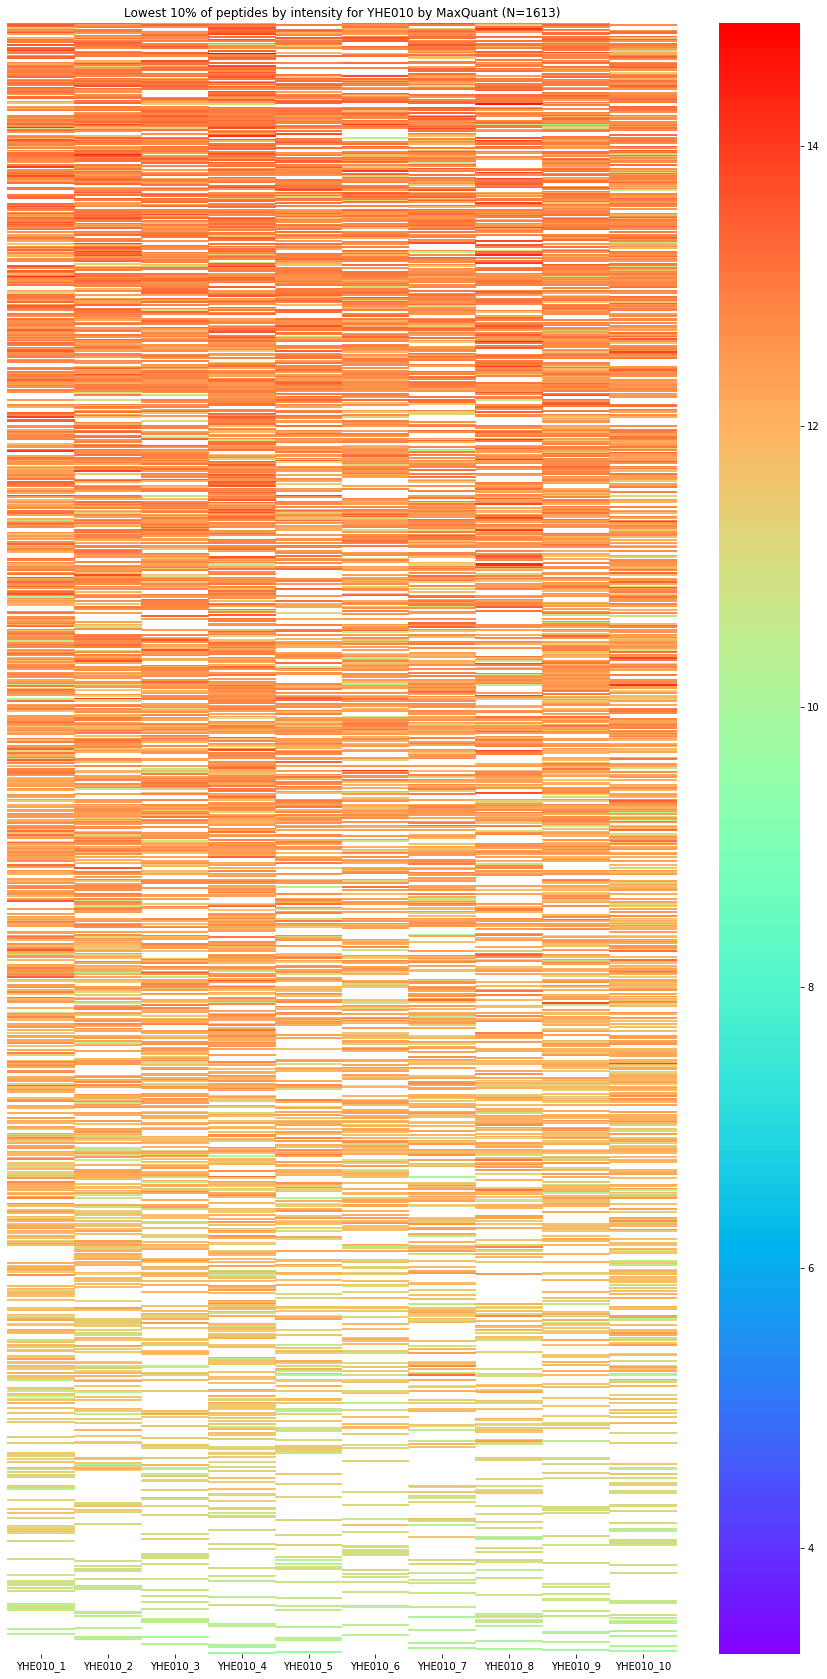

In [61]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE010 by MaxQuant (N={})'.format(int(lower_proportion*100), len(occurences_df)))

#### plot YHE114

In [62]:
run_names_l = sorted(list(mq_sequences_df[mq_sequences_df.group == 'YHE114'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [63]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe114_lowest_df.itertuples():
    run_occurences_df = mq_sequences_df[(mq_sequences_df.sequence == row.sequence) & (mq_sequences_df.modifications == row.modifications) & (mq_sequences_df.charge == row.charge) & (mq_sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE114 by MaxQuant (N=1811)')

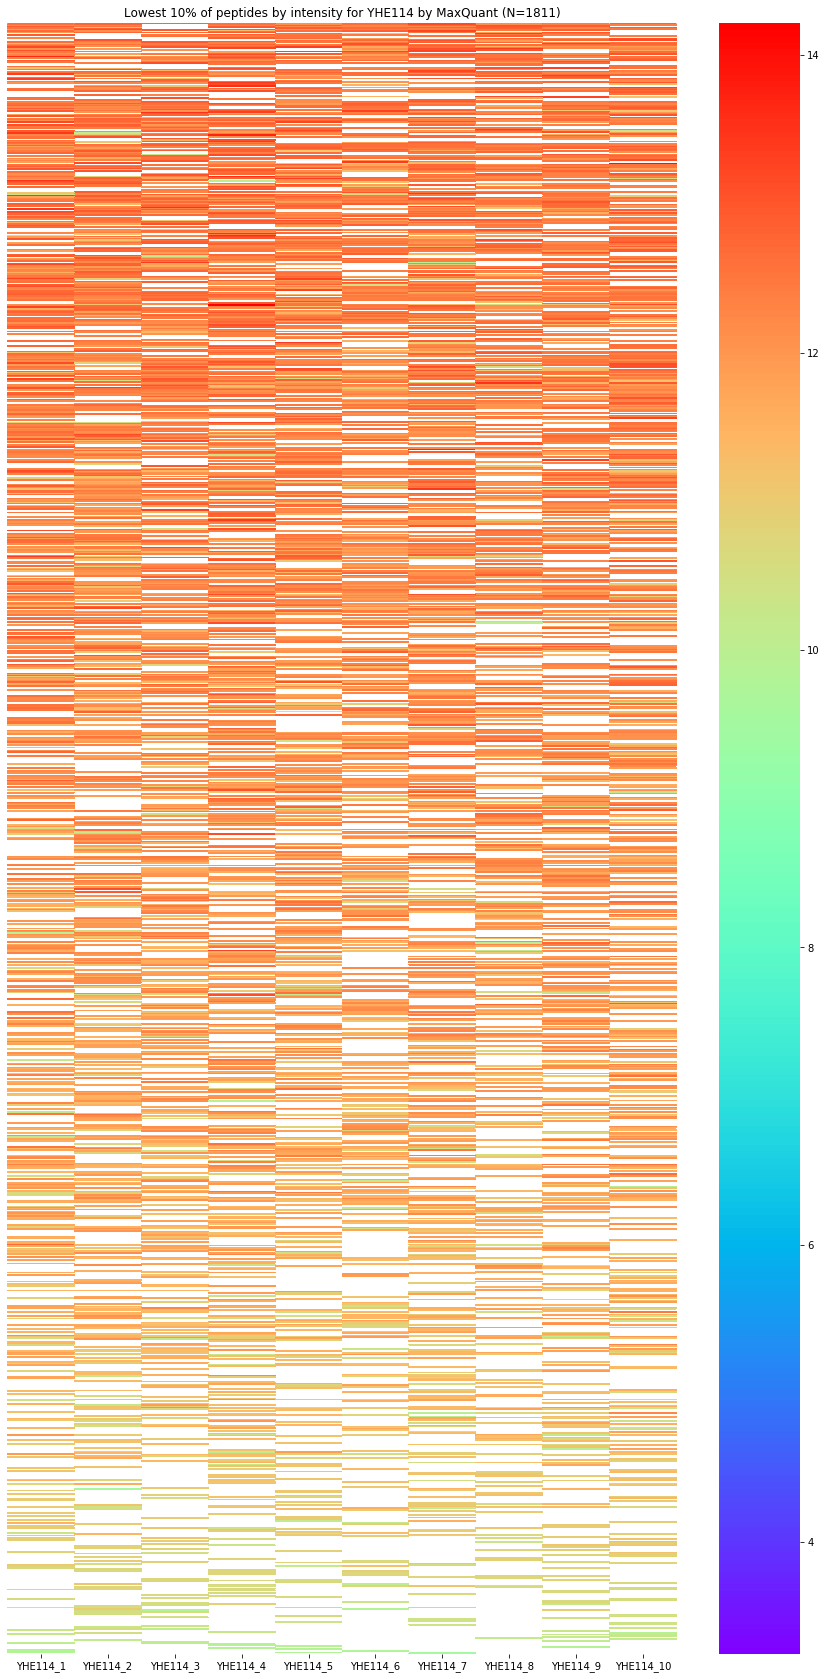

In [64]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE114 by MaxQuant (N={})'.format(int(lower_proportion*100), len(occurences_df)))

#### plot YHE211

In [65]:
run_names_l = sorted(list(mq_sequences_df[mq_sequences_df.group == 'YHE211'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [66]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe211_lowest_df.itertuples():
    run_occurences_df = mq_sequences_df[(mq_sequences_df.sequence == row.sequence) & (mq_sequences_df.modifications == row.modifications) & (mq_sequences_df.charge == row.charge) & (mq_sequences_df.group == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE211 by MaxQuant (N=1833)')

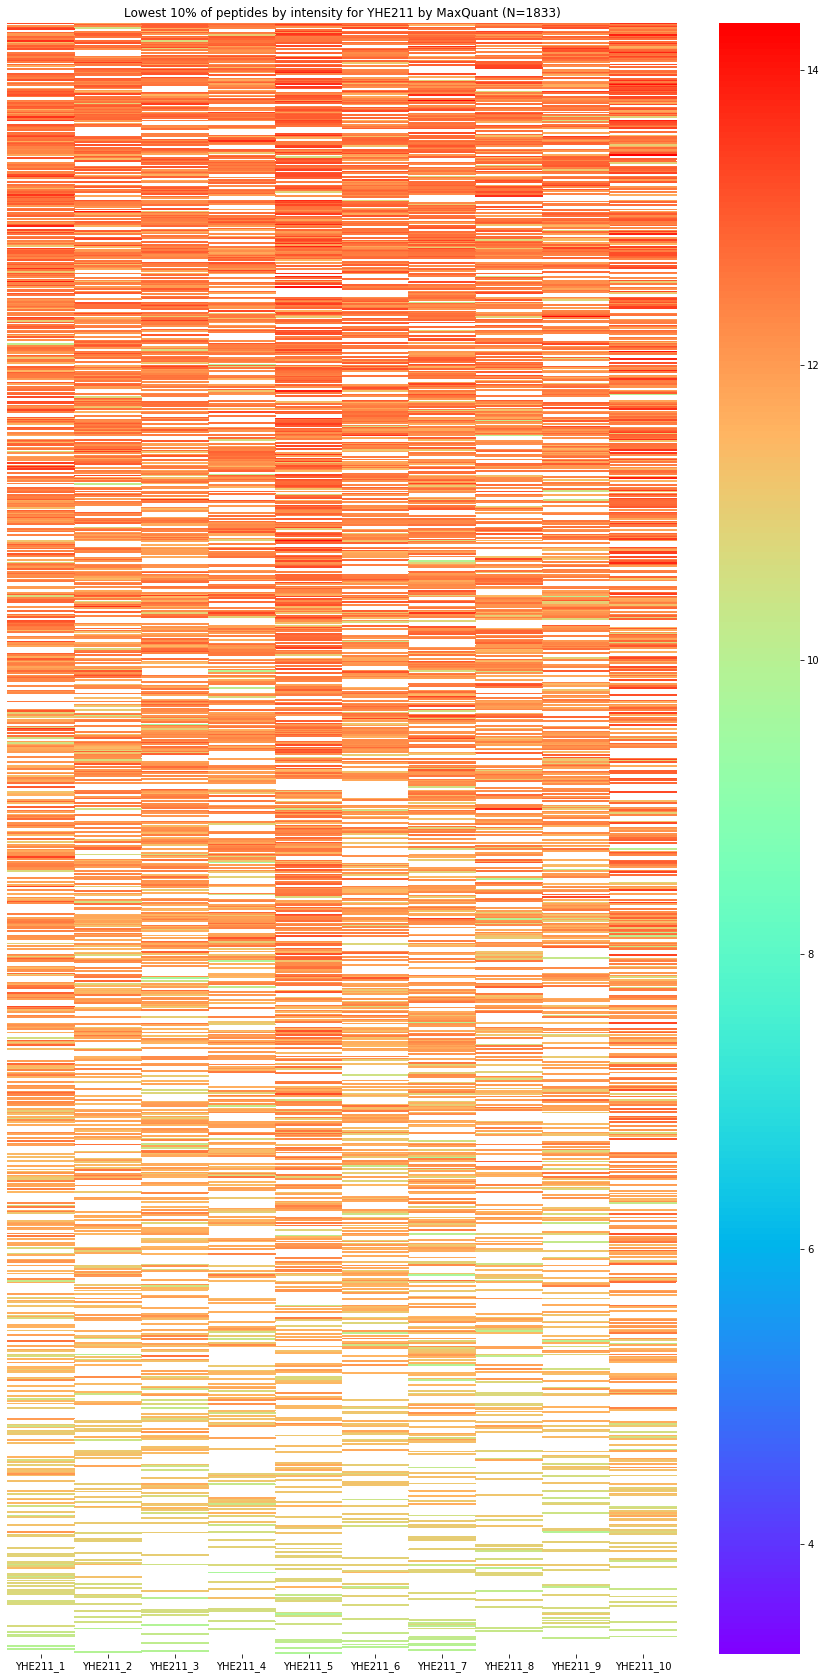

In [67]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE211 by MaxQuant (N={})'.format(int(lower_proportion*100), len(occurences_df)))

## Fragger heatmaps

In [68]:
# use the analysis with MBR
fragger_results_df = pd.read_csv('{}/MSstats-P3856.csv'.format(EXPERIMENT_DIR), sep=',')

In [69]:
fragger_sequences_df = fragger_results_df.copy()
fragger_sequences_df.columns

Index(['ProteinName', 'PeptideSequence', 'PrecursorCharge', 'FragmentIon',
       'ProductCharge', 'IsotopeLabelType', 'Condition', 'BioReplicate', 'Run',
       'Intensity'],
      dtype='object')

In [70]:
fragger_sequences_df['short_run_name'] = fragger_sequences_df.apply(lambda row: '_'.join(row.Run.split('_Slot')[0].split('_')[1:3]), axis=1)

In [71]:
fragger_sequences_df['species'] = fragger_sequences_df.apply(lambda row: classify_protein(row.ProteinName), axis=1)

In [72]:
fragger_sequences_df = fragger_sequences_df[fragger_sequences_df.Intensity.notnull()]
fragger_sequences_df = fragger_sequences_df[fragger_sequences_df.Intensity > 0]

In [73]:
fragger_sequences_df.sample(n=3)

,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity,short_run_name,species
739434,sp|Q9UNZ2|NSF1C_HUMAN,LGSTAPQVLSTSSPAQQAENEAK,2,NaN,NaN,L,YHE211,4,P3856_YHE211_4_Slot1-1_1_5107,85203.734,YHE211_4,HUMAN
531192,sp|Q16822|PCKGM_HUMAN,LGTPVLQALGDGDFVK,2,NaN,NaN,L,YHE114,2,P3856_YHE114_2_Slot1-1_1_5116,12096.002,YHE114_2,HUMAN
589471,sp|Q8NBJ5|GT251_HUMAN,MLPVDEFLPVMFDK,2,NaN,NaN,L,YHE010,1,P3856_YHE010_1_Slot1-1_1_5093,26234.744,YHE010_1,HUMAN


In [74]:
# find the mean intensity for each peptide in each group
fragger_intensities_l = []
for group_name,group_df in fragger_sequences_df.groupby(['PeptideSequence','PrecursorCharge','Condition'], as_index=False):
    mean_intensity = group_df.Intensity.mean()
    fragger_intensities_l.append((group_name[0], group_name[1], group_name[2], mean_intensity))
fragger_intensities_df = pd.DataFrame(fragger_intensities_l, columns=['sequence', 'charge', 'group', 'group_mean_intensity'])

In [75]:
# sort each group by descending intensity
fragger_intensities_df.sort_values(by=['group_mean_intensity'], ascending=False, inplace=True)

In [76]:
fragger_intensities_df.tail()

,sequence,charge,group,group_mean_intensity
48241,VC[57.0215]NYVNWIQQTIAAN,2,YHE211,357.09050
43509,STSSETDC[57.0215]NDNVPSHK,2,YHE114,324.62850
39256,RDLPNALDEK,2,YHE010,290.59800
14658,FNLSVIEDPSMK,2,YHE211,247.62599
137,AAGALLNGPPQFSTAPEIK,2,YHE010,214.77450


In [77]:
# make a separate DF for each group
yhe010_df = fragger_intensities_df[(fragger_intensities_df.group == 'YHE010')].copy()
yhe114_df = fragger_intensities_df[(fragger_intensities_df.group == 'YHE114')].copy()
yhe211_df = fragger_intensities_df[(fragger_intensities_df.group == 'YHE211')].copy()

In [78]:
# find the lowest-intensity peptides in each group
lower_proportion = 0.1
yhe010_lowest_df = yhe010_df.tail(int(lower_proportion * len(yhe010_df)))
yhe114_lowest_df = yhe114_df.tail(int(lower_proportion * len(yhe114_df)))
yhe211_lowest_df = yhe211_df.tail(int(lower_proportion * len(yhe211_df)))

#### plot YHE010

In [79]:
run_names_l = sorted(list(fragger_sequences_df[fragger_sequences_df.Condition == 'YHE010'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [80]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe010_lowest_df.itertuples():
    run_occurences_df = fragger_sequences_df[(fragger_sequences_df.PeptideSequence == row.sequence) & (fragger_sequences_df.PrecursorCharge == row.charge) & (fragger_sequences_df.Condition == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.Intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE010 by MSFragger (N=1785)')

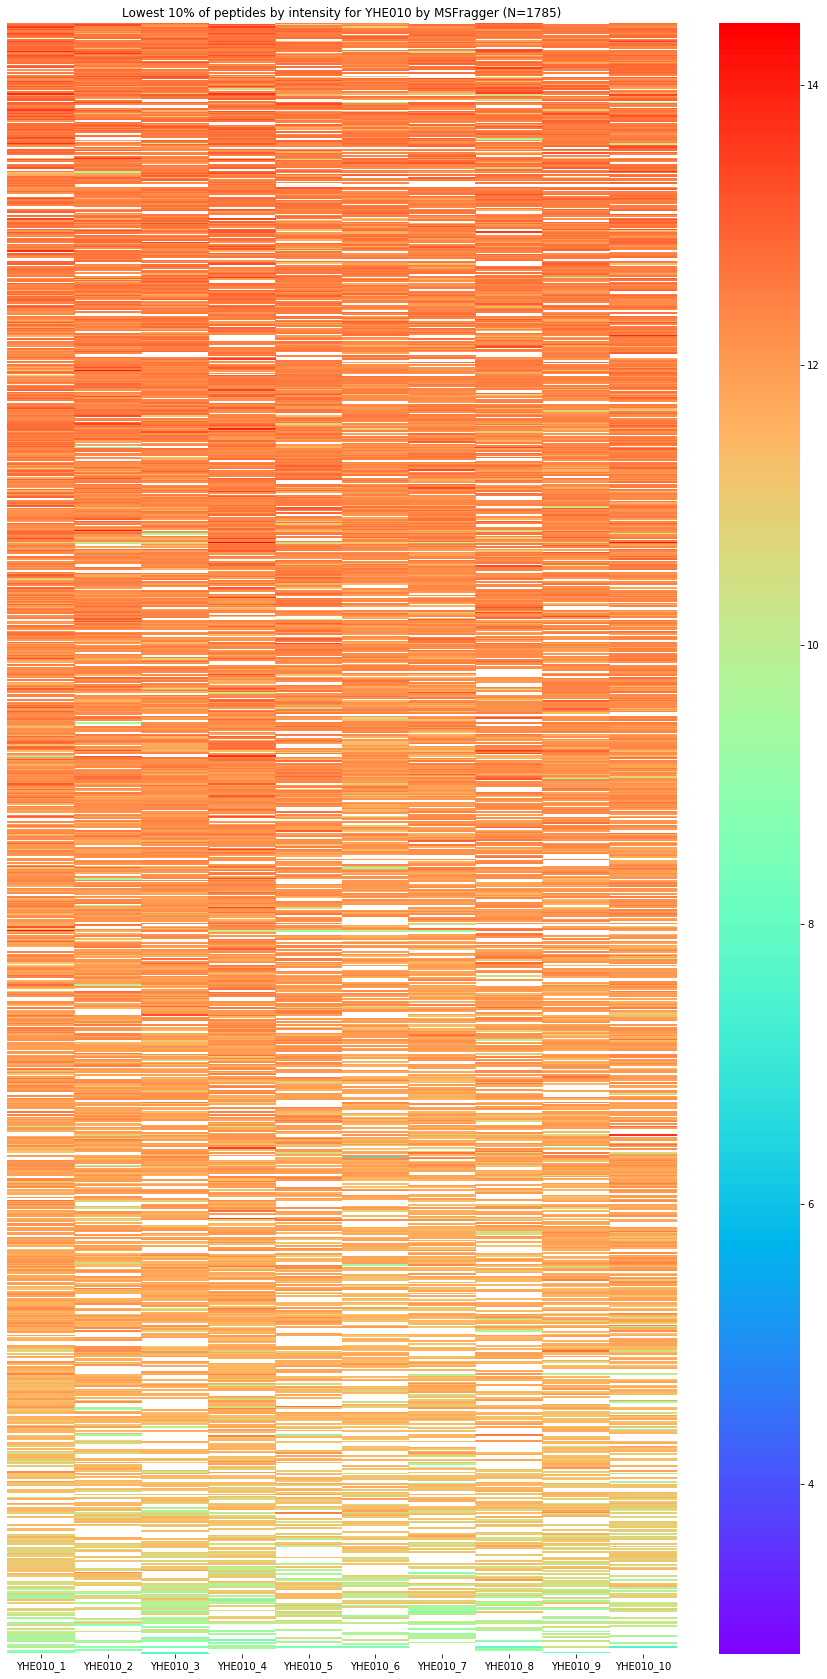

In [81]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE010 by MSFragger (N={})'.format(int(lower_proportion*100), len(occurences_df)))

#### plot YHE114

In [82]:
run_names_l = sorted(list(fragger_sequences_df[fragger_sequences_df.Condition == 'YHE114'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [83]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe114_lowest_df.itertuples():
    run_occurences_df = fragger_sequences_df[(fragger_sequences_df.PeptideSequence == row.sequence) & (fragger_sequences_df.PrecursorCharge == row.charge) & (fragger_sequences_df.Condition == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.Intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE114 by MSFragger (N=1887)')

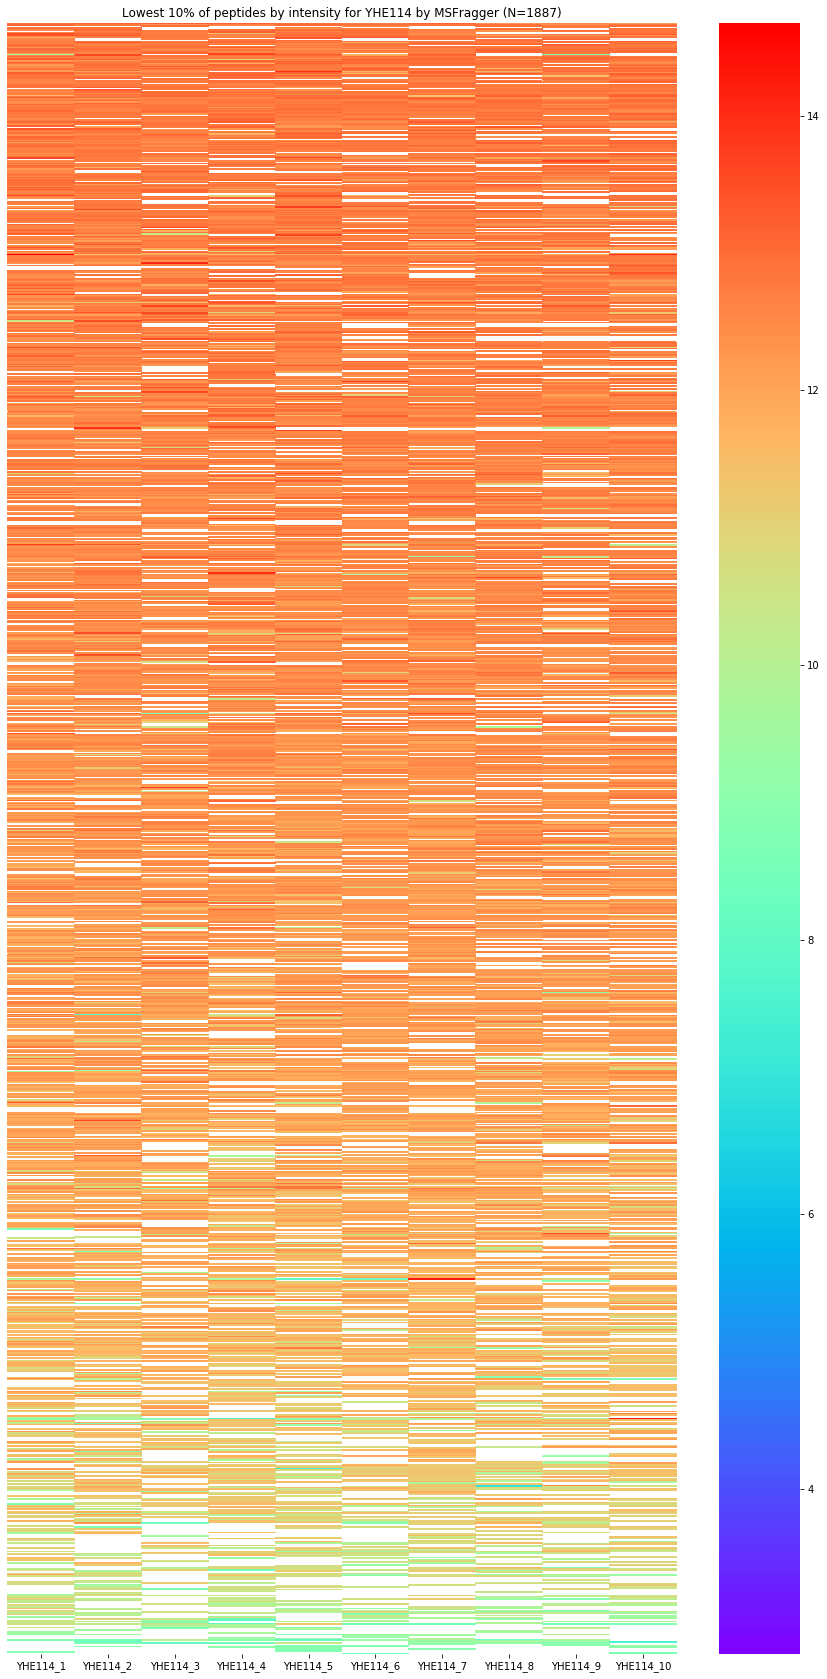

In [84]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE114 by MSFragger (N={})'.format(int(lower_proportion*100), len(occurences_df)))

#### plot YHE211

In [85]:
run_names_l = sorted(list(fragger_sequences_df[fragger_sequences_df.Condition == 'YHE211'].short_run_name.unique()), key=lambda x: int(x.split('_')[1]))
occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))

In [86]:
# as a heatmap, plot the missing-ness across this group of runs
occurences_l = []
index_l = []
for row in yhe211_lowest_df.itertuples():
    run_occurences_df = fragger_sequences_df[(fragger_sequences_df.PeptideSequence == row.sequence) & (fragger_sequences_df.PrecursorCharge == row.charge) & (fragger_sequences_df.Condition == row.group)]
    occurences_d = dict(zip(run_names_l, [0] * len(run_names_l)))
    index_l.append('{},{}'.format(row.sequence, row.charge))
    for r in run_occurences_df.itertuples():
        occurences_d[r.short_run_name] = np.log2(r.Intensity)
    occurences_l.append(occurences_d)
occurences_df = pd.DataFrame(occurences_l, columns=occurences_d.keys(), index=index_l)

Text(0.5, 1, 'Lowest 10% of peptides by intensity for YHE211 by MaxQuant (N=1935)')

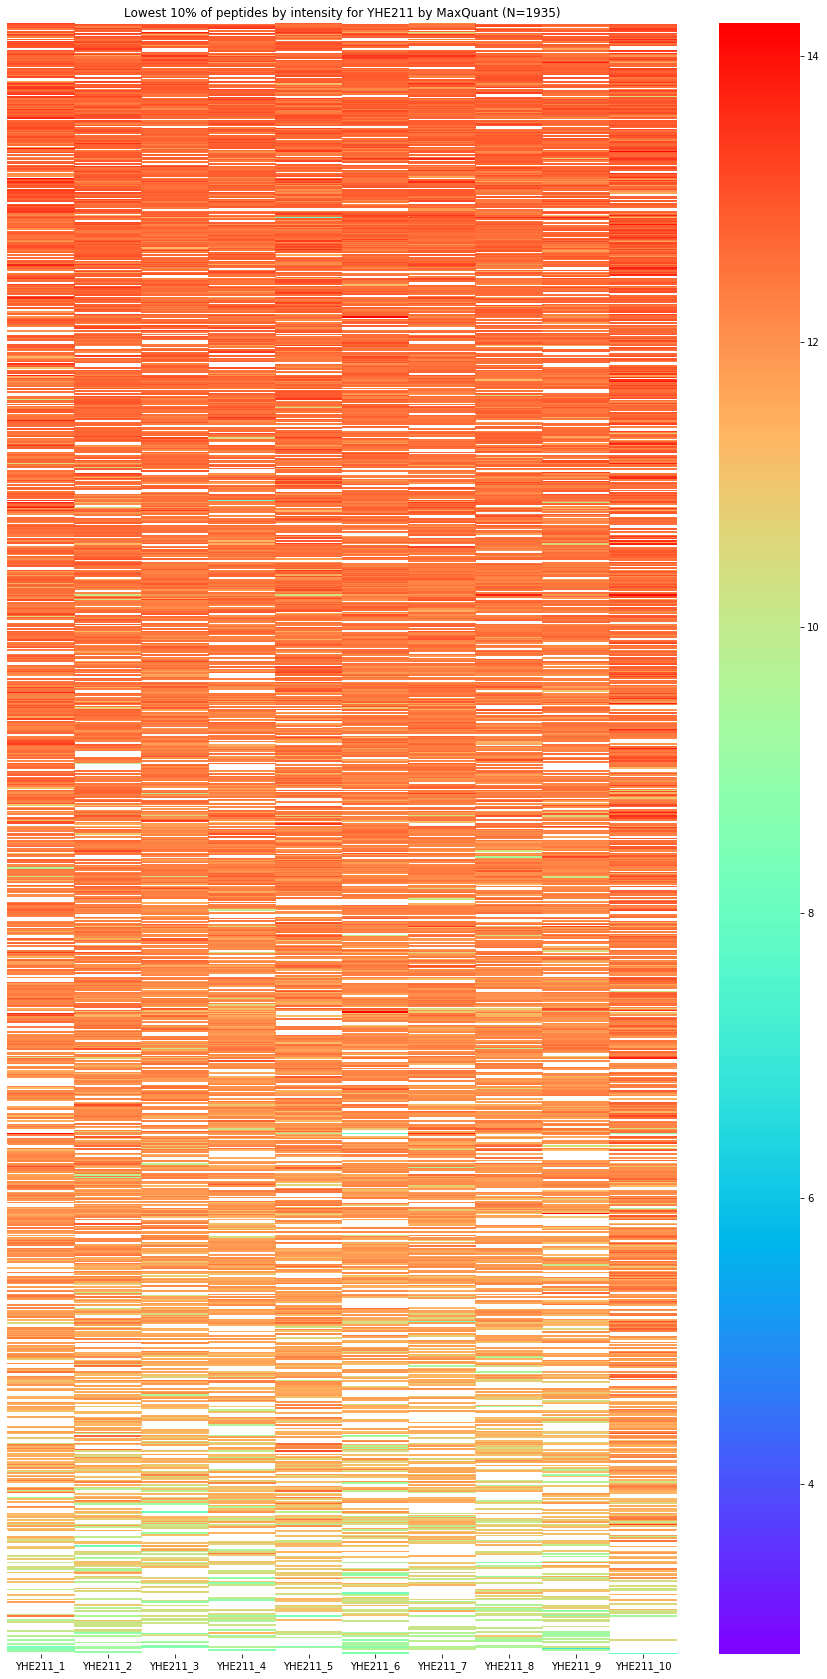

In [87]:
plt.figure(figsize=(15,30))
a = occurences_df.to_numpy()
hm = sns.heatmap(occurences_df, cmap='rainbow', vmin=np.log2(a[a > 0].min()), mask=(occurences_df==0))
hm.set(yticklabels=[])
hm.set(ylabel=None)
hm.tick_params(left=False)
plt.title('Lowest {}% of peptides by intensity for YHE211 by MaxQuant (N={})'.format(int(lower_proportion*100), len(occurences_df)))

## visualise the percentage of missing values across runs

#### prepare TFD/E results

In [88]:
subset_groups = ['YHE114']

In [89]:
tfde_subset_df = sequences_df[(sequences_df.group.isin(subset_groups))]

In [90]:
number_of_runs_in_subset = len(tfde_subset_df.short_run_name.unique())
print('there are {} {} runs in the experiment'.format(number_of_runs_in_subset, subset_groups))

there are 10 ['YHE114'] runs in the experiment


In [91]:
number_of_unique_sequences_tfde = len(tfde_subset_df.drop_duplicates(subset=['sequence', 'charge'], keep='first', inplace=False))
number_of_unique_sequences_tfde

22520

In [92]:
# count how many runs each sequence/charge was extracted from and classified as a target
sequence_occurences_l = []
for group_name,group_df in tfde_subset_df.groupby(['sequence','charge'], as_index=False):
    sequence_occurences_l.append((group_name, len(group_df.short_run_name.unique()), group_name[0], group_name[1]))
tfde_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence_charge','number_of_runs_extracted','sequence','charge'])

In [93]:
tfde_sequence_occurences_df['missing_files'] = number_of_runs_in_subset - tfde_sequence_occurences_df.number_of_runs_extracted

In [94]:
# display the number of missing values across the subset
tfde_missing_values = tfde_sequence_occurences_df.missing_files.sum() / (len(tfde_sequence_occurences_df) * number_of_runs_in_subset)

In [95]:
tfde_sequence_occurences_df.sample(n=3)

,sequence_charge,number_of_runs_extracted,sequence,charge,missing_files
15078,"(QLGDNEAITQEIVGCAHLENYALK, 3)",10,QLGDNEAITQEIVGCAHLENYALK,3,0
20827,"(VPMGSGQEAAVPVTWTEIFSGK, 2)",10,VPMGSGQEAAVPVTWTEIFSGK,2,0
14982,"(QIFLWDVNTLTALTASNNTVTTSSLSGNK, 3)",10,QIFLWDVNTLTALTASNNTVTTSSLSGNK,3,0


In [96]:
run_count_l = []
for number_of_runs in range(1,number_of_runs_in_subset+1):
    run_count_l.append((number_of_runs, len(tfde_sequence_occurences_df[tfde_sequence_occurences_df.number_of_runs_extracted >= number_of_runs])))
tfde_run_count_df = pd.DataFrame(run_count_l, columns=['run_count','number_of_sequences'])

In [97]:
tfde_run_count_df['percent_quantified'] = tfde_run_count_df.number_of_sequences / number_of_unique_sequences_tfde * 100

#### prepare MQ results

In [98]:
mq_sequences_df.columns

Index(['sequence', 'modifications', 'charge', 'species', 'short_run_name',
       'group', 'identified_in_file', 'score', 'intensity'],
      dtype='object')

In [99]:
mq_subset_df = mq_sequences_df[(mq_sequences_df.group.isin(subset_groups))]

In [100]:
number_of_unique_sequences_mq = len(mq_subset_df.drop_duplicates(subset=['sequence','modifications','charge'], keep='first', inplace=False))
number_of_unique_sequences_mq

18112

In [101]:
# count how many runs each sequence/charge was extracted from
sequence_occurences_l = []
for group_name,group_df in mq_subset_df.groupby(['sequence', 'modifications', 'charge'], as_index=False):
    sequence_occurences_l.append((group_name[0], group_name[1], group_name[2], len(group_df.short_run_name.unique())))
mq_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence','modifications','charge','number_of_runs_extracted'])

In [102]:
run_count_l = []
for number_of_runs in range(1,number_of_runs_in_subset+1):
    run_count_l.append((number_of_runs, len(mq_sequence_occurences_df[mq_sequence_occurences_df.number_of_runs_extracted >= number_of_runs])))
mq_run_count_df = pd.DataFrame(run_count_l, columns=['run_count','number_of_sequences'])

In [103]:
mq_sequence_occurences_df['missing_files'] = number_of_runs_in_subset - mq_sequence_occurences_df.number_of_runs_extracted
mq_run_count_df['percent_quantified'] = mq_run_count_df.number_of_sequences / number_of_unique_sequences_mq * 100

In [104]:
# display the number of missing values across the subset
mq_missing_values = mq_sequence_occurences_df.missing_files.sum() / (len(mq_sequence_occurences_df) * number_of_runs_in_subset)

#### prepare Fragger results

In [105]:
fragger_subset_df = fragger_sequences_df[(fragger_sequences_df.Condition.isin(subset_groups))]

In [106]:
number_of_unique_sequences_fragger = len(fragger_subset_df.drop_duplicates(subset=['PeptideSequence', 'PrecursorCharge'], keep='first', inplace=False))
number_of_unique_sequences_fragger

18878

In [107]:
# count how many runs each sequence/charge was found in
sequence_occurences_l = []
for group_name,group_df in fragger_subset_df.groupby(['PeptideSequence','PrecursorCharge'], as_index=False):
    sequence_occurences_l.append((group_name[0], group_name[1], len(group_df.short_run_name.unique())))
fragger_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence','charge','number_of_runs_extracted'])

In [108]:
run_count_l = []
for number_of_runs in range(1,number_of_runs_in_subset+1):
    run_count_l.append((number_of_runs, len(fragger_sequence_occurences_df[fragger_sequence_occurences_df.number_of_runs_extracted >= number_of_runs])))
fragger_run_count_df = pd.DataFrame(run_count_l, columns=['run_count','number_of_sequences'])

In [109]:
fragger_sequence_occurences_df['missing_files'] = number_of_runs_in_subset - fragger_sequence_occurences_df.number_of_runs_extracted
fragger_run_count_df['percent_quantified'] = fragger_run_count_df.number_of_sequences / number_of_unique_sequences_fragger * 100

In [110]:
# display the number of missing values across the subset
fragger_missing_values = fragger_sequence_occurences_df.missing_files.sum() / (len(fragger_sequence_occurences_df) * number_of_runs_in_subset)

#### now plot the results

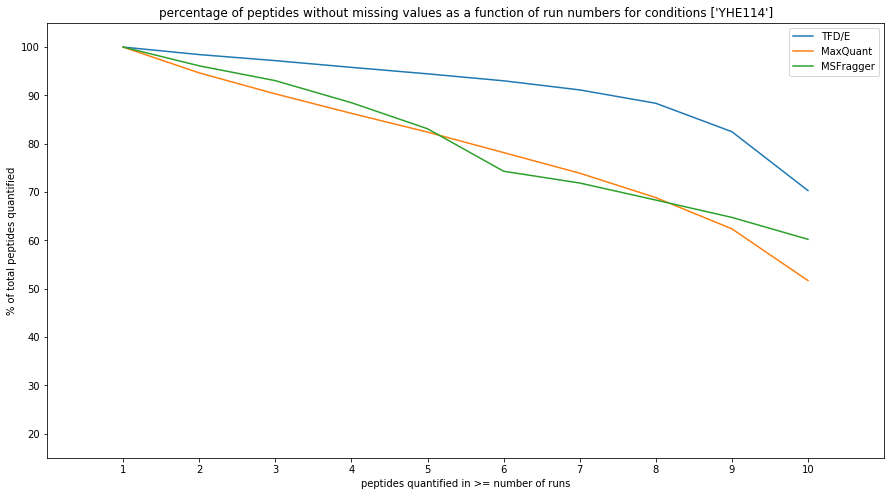

In [111]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('percentage of peptides without missing values as a function of run numbers for conditions {}'.format(subset_groups))

ax1.plot(tfde_run_count_df.run_count, tfde_run_count_df.percent_quantified, label='TFD/E')
ax1.plot(mq_run_count_df.run_count, mq_run_count_df.percent_quantified, label='MaxQuant')
ax1.plot(fragger_run_count_df.run_count, fragger_run_count_df.percent_quantified, label='MSFragger')

plt.xlabel('peptides quantified in >= number of runs')
plt.ylabel('% of total peptides quantified')
plt.ylim((15,105))
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
plt.legend(loc="best")

plt.show()

## missing-ness distributions

#### plot TFD/E results

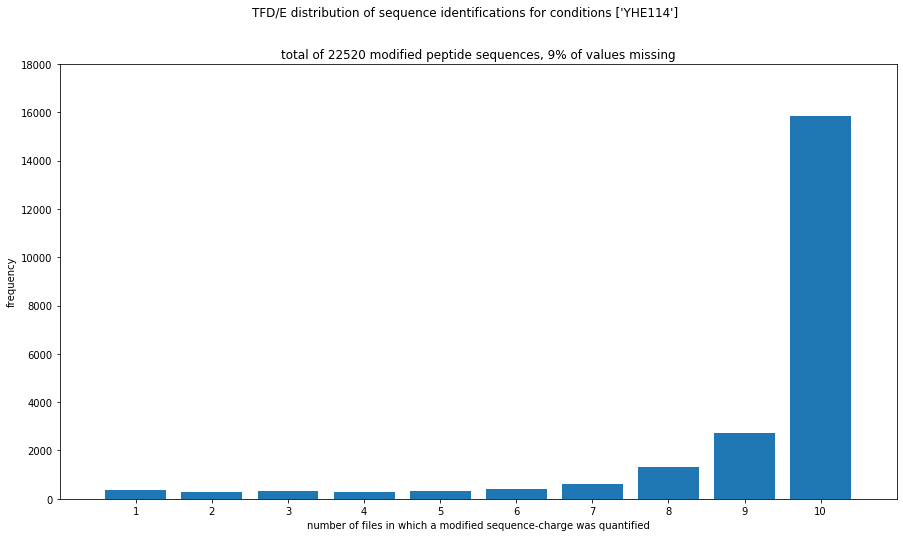

In [112]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('TFD/E distribution of sequence identifications for conditions {}'.format(subset_groups))
plt.title('total of {} modified peptide sequences, {}% of values missing'.format(number_of_unique_sequences_tfde, int(round(tfde_missing_values*100))))

counts = np.bincount(tfde_sequence_occurences_df.number_of_runs_extracted)
ax1.bar(range(number_of_runs_in_subset+1), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was quantified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
plt.ylim((0,18000))

plt.show()

#### plot MQ results

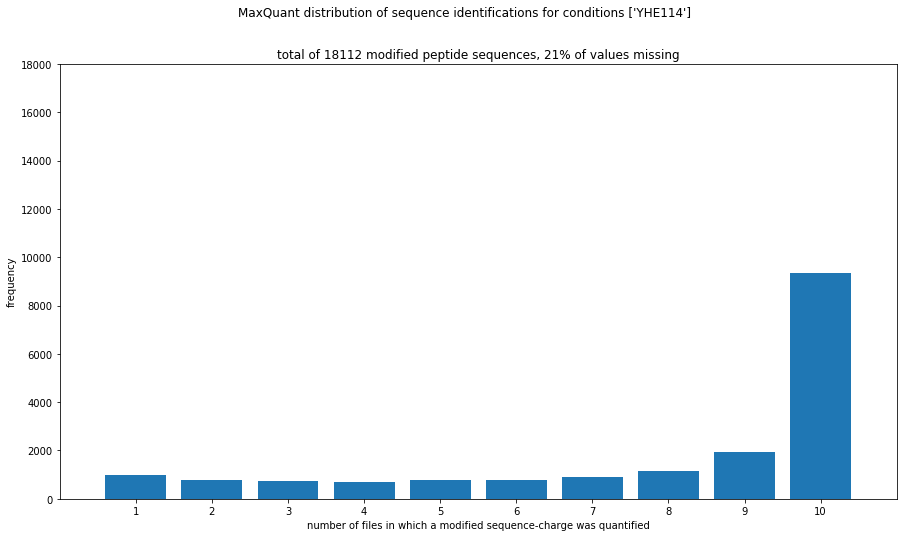

In [113]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('MaxQuant distribution of sequence identifications for conditions {}'.format(subset_groups))
plt.title('total of {} modified peptide sequences, {}% of values missing'.format(number_of_unique_sequences_mq, int(round(mq_missing_values*100))))

counts = np.bincount(mq_sequence_occurences_df.number_of_runs_extracted)
ax1.bar(range(number_of_runs_in_subset+1), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was quantified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
plt.ylim((0,18000))

plt.show()

#### plot Fragger results

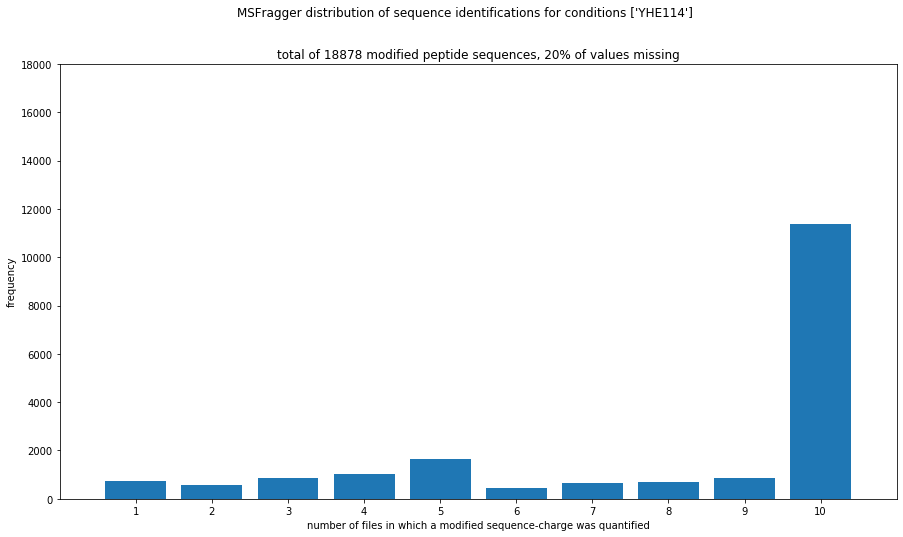

In [114]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('MSFragger distribution of sequence identifications for conditions {}'.format(subset_groups))
plt.title('total of {} modified peptide sequences, {}% of values missing'.format(number_of_unique_sequences_fragger, int(round(fragger_missing_values*100))))

counts = np.bincount(fragger_sequence_occurences_df.number_of_runs_extracted)
ax1.bar(range(number_of_runs_in_subset+1), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was quantified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,number_of_runs_in_subset+1), xlim=[0, number_of_runs_in_subset+1])
plt.ylim((0,18000))

plt.show()

## distribution of quantitative intensities

#### prepare TFD/E results

In [115]:
tfde_subset_df.sample(n=3)

,sequence,charge,id_perc_q_value,protein,species,short_run_name,group,intensity,identified_in_run
216150,IEEAMDGSETPQLFTVLPEK,2,0.000004,sp|Q13435|SF3B2_HUMAN,HUMAN,YHE114_8,YHE114,764,False
224771,IIQIDINPASIGAHSK,2,0.001595,sp|P07003|POXB_ECOLI,E.COLI,YHE114_1,YHE114,27,False
261806,LEEYAGFVFINM[15.9949]DPNATSVEDQLPGLGAK,3,0.003811,sp|P0ABR7|CNTA_ECOLI,E.COLI,YHE114_10,YHE114,465,False


In [116]:
# calculate the intensity mean for peptides without missing values
tfde_intensities_l = []
for group_name,group_df in tfde_subset_df.groupby(['sequence','charge'], as_index=False):
    if len(group_df.short_run_name.unique()) == number_of_runs_in_subset:
        intensity_mean = group_df.intensity.mean()
        tfde_intensities_l.append((','.join([group_name[0],group_name[1].astype('str')]),intensity_mean,'TFD/E'))
tfde_intensities_df = pd.DataFrame(tfde_intensities_l, columns=['sequence','intensity','method'])
tfde_intensities_df['intensity_adjusted'] = tfde_intensities_df.intensity - np.min(tfde_intensities_df.intensity)
tfde_intensities_df.intensity_adjusted.replace(to_replace=[0.0], value=1.0, inplace=True)

#### prepare MQ results

In [117]:
mq_subset_df.sample(n=3)

,sequence,modifications,charge,species,short_run_name,group,identified_in_file,score,intensity
94328,EVVAASHELGQDYEHVTMLR,Unmodified,3,HUMAN,YHE114_3,YHE114,False,170.530,27022.0
250927,NAEPLINLDVNNPDFK,Unmodified,2,HUMAN,YHE114_8,YHE114,False,141.320,65009.0
65139,DYFEEYGK,Unmodified,1,HUMAN,YHE114_1,YHE114,True,58.426,65129.0


In [118]:
# calculate the intensity mean for peptides without missing values
mq_intensities_l = []
for group_name,group_df in mq_subset_df.groupby(['sequence','modifications','charge'], as_index=False):
    if len(group_df.short_run_name.unique()) == number_of_runs_in_subset:
        intensity_mean = group_df.intensity.mean()
        mq_intensities_l.append((','.join([group_name[0],group_name[1],group_name[2].astype('str')]),intensity_mean,'MaxQuant'))
mq_intensities_df = pd.DataFrame(mq_intensities_l, columns=['sequence','intensity','method'])
mq_intensities_df['intensity_adjusted'] = mq_intensities_df.intensity - np.min(mq_intensities_df.intensity)
mq_intensities_df.intensity_adjusted.replace(to_replace=[0.0], value=1.0, inplace=True)

#### prepare Fragger results

In [119]:
fragger_subset_df.sample(n=3)

,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity,short_run_name,species
478697,sp|Q13200|PSMD2_HUMAN,MNLASSFVNGFVNAAFGQDK,2,NaN,NaN,L,YHE114,7,P3856_YHE114_7_Slot1-1_1_5121,62047.992,YHE114_7,HUMAN
411019,sp|P63010|AP2B1_HUMAN,APEVSQYIYQVYDSILK,3,NaN,NaN,L,YHE114,9,P3856_YHE114_9_Slot1-1_1_5123,19798.965,YHE114_9,HUMAN
257597,sp|P31943|HNRH1_HUMAN,DLNYC[57.0215]FSGMSDHR,2,NaN,NaN,L,YHE114,7,P3856_YHE114_7_Slot1-1_1_5121,249105.920,YHE114_7,HUMAN


In [120]:
# calculate the intensity mean for peptides without missing values
fragger_intensities_l = []
for group_name,group_df in fragger_subset_df.groupby(['PeptideSequence', 'PrecursorCharge'], as_index=False):
    if len(group_df['Run'].unique()) == number_of_runs_in_subset:
        intensity_mean = group_df.Intensity.mean()
        fragger_intensities_l.append((','.join([group_name[0],group_name[1].astype('str')]),intensity_mean,'MSFragger'))
fragger_intensities_df = pd.DataFrame(fragger_intensities_l, columns=['sequence','intensity','method'])
fragger_intensities_df['intensity_adjusted'] = fragger_intensities_df.intensity - np.min(fragger_intensities_df.intensity)
fragger_intensities_df.intensity_adjusted.replace(to_replace=[0.0], value=1.0, inplace=True)

In [121]:
tfde_intensities_df['intensity_log'] = np.log10(tfde_intensities_df.intensity)
mq_intensities_df['intensity_log'] = np.log10(mq_intensities_df.intensity)
fragger_intensities_df['intensity_log'] = np.log10(fragger_intensities_df.intensity)

In [122]:
tfde_intensities_df['intensity_adjusted_log'] = tfde_intensities_df.intensity_log - np.min(tfde_intensities_df.intensity_log)
mq_intensities_df['intensity_adjusted_log'] = mq_intensities_df.intensity_log - np.min(mq_intensities_df.intensity_log)
fragger_intensities_df['intensity_adjusted_log'] = fragger_intensities_df.intensity_log - np.min(fragger_intensities_df.intensity_log)

#### consolidate the data

In [123]:
intensities_l = [tfde_intensities_df,mq_intensities_df,fragger_intensities_df]
intensities_df = pd.concat(intensities_l, sort=False)

In [124]:
intensities_df.sample(n=3)

,sequence,intensity,method,intensity_adjusted,intensity_log,intensity_adjusted_log
13715,"TYSYLTPDLWK,2",1283.3000,TFD/E,1120.80000,3.108328,0.897475
177,"AEVSDVGNAILDGADCVMLSGETAK,Unmodified,2",94721.2000,MaxQuant,90254.26000,4.976447,1.326437
8472,"SLSALGNVISALAEGSTYVPYR,3",31111.4577,MSFragger,28404.15756,4.492920,1.060384


#### produce the plot

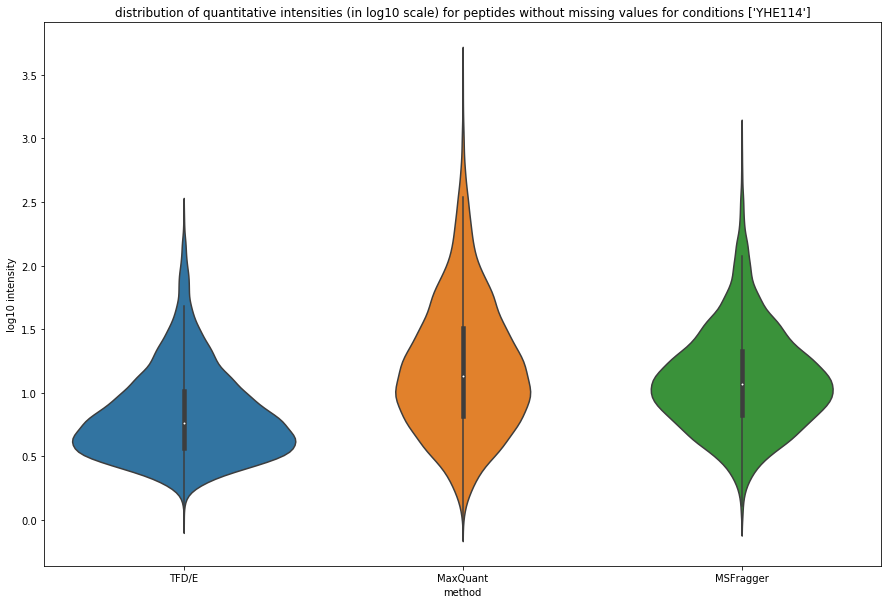

In [125]:
plt.figure(figsize=(15,10))
ax = sns.violinplot(x=intensities_df.method, y=intensities_df.intensity_adjusted_log)
_ = plt.ylabel("log10 intensity")
_ = plt.title('distribution of quantitative intensities (in log10 scale) for peptides without missing values for conditions {}'.format(subset_groups))

In [126]:
# orders of magnitude
intensities_df.groupby('method')['intensity_adjusted_log'].agg(np.ptp)

/Users/darylwilding-mcbride/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


method
MSFragger    3.023449
MaxQuant     3.552658
TFD/E        2.429305
Name: intensity_adjusted_log, dtype: float64

In [127]:
# number of peptides that have no missing values
intensities_df.groupby('method')['intensity_adjusted_log'].count()

method
MSFragger    11368
MaxQuant      9359
TFD/E        15832
Name: intensity_adjusted_log, dtype: int64

## distribution of CV

#### TFD/E analysis

In [128]:
tfde_subset_df.sample(n=3)

,sequence,charge,id_perc_q_value,protein,species,short_run_name,group,intensity,identified_in_run
217630,IESDVQEPTEPEDDLDIMLGNK,2,0.000004,sp|P20042|IF2B_HUMAN,HUMAN,YHE114_5,YHE114,651,True
29500,APPKPCAGNQGTQITVEDLFYNIATR,3,0.000004,sp|P40692|MLH1_HUMAN,HUMAN,YHE114_8,YHE114,250,False
23790,ALSSLELSSHLAK,2,0.000024,sp|Q9BPX3|CND3_HUMAN,HUMAN,YHE114_10,YHE114,679,False


In [129]:
# for each sequence, find the CV
sequence_cv_l = []
for group_name,group_df in tfde_subset_df.groupby(['sequence','charge']):
    if len(group_df) >= 2:
        intensity_cv = np.std(group_df.intensity) / np.mean(group_df.intensity)
        sequence_cv_l.append((group_name[0], group_name[1], intensity_cv))
sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','charge','intensity_cv'])

In [130]:
sequence_cv_df.sample(n=3)

,sequence,charge,intensity_cv
19252,TVWDWELMNDIKPIWQRPSK,3,0.125938
3198,DTDVVFPVHFLMNK,2,0.210593
20290,VMEMFQPSAVVLQCGSDSLSGDR,2,0.258398


In [131]:
sequence_cv_df[sequence_cv_df.intensity_cv > 0.25].sample(n=5)

,sequence,charge,intensity_cv
7770,HELQANCYEEVK,2,0.341717
3849,EEIFGPVQPLFK,2,0.281985
15345,Q[-17.0265]DHLNGAVSGSVQASDR,2,0.347527
314,AEGAAMLELVGSILR,2,0.254329
2524,DHANYEEDENGDITPIK,2,0.296245


In [132]:
results_df[(results_df.sequence == 'HVLTGSADNSCR') & (results_df.charge == 2)]

,sequence,charge,identifications,extractions,identifications_d,id_perc_q_value,id_count_all_runs,id_count_human_only_runs,id_number_of_proteins,id_protein,id_species,extractions_l,ext_count_all_runs,ext_count_human_only_runs
8799,HVLTGSADNSCR,2,"{""perc_q_value"": 3.817231e-06, ""run_names"": [""...","[{""run_name"": ""P3856_YHE211_6_Slot1-1_1_5109"",...","{'perc_q_value': 3.817231e-06, 'run_names': ['...",0.000004,30,10,1,sp|Q13347|EIF3I_HUMAN,HUMAN,"[{'run_name': 'P3856_YHE211_6_Slot1-1_1_5109',...",30,10


In [133]:
tfde_subset_df[(tfde_subset_df.sequence == 'HVLTGSADNSCR') & (tfde_subset_df.charge == 2)]

,sequence,charge,id_perc_q_value,protein,species,short_run_name,group,intensity,identified_in_run
208232,HVLTGSADNSCR,2,0.000004,sp|Q13347|EIF3I_HUMAN,HUMAN,YHE114_2,YHE114,194,True
208233,HVLTGSADNSCR,2,0.000004,sp|Q13347|EIF3I_HUMAN,HUMAN,YHE114_10,YHE114,458,True
208234,HVLTGSADNSCR,2,0.000004,sp|Q13347|EIF3I_HUMAN,HUMAN,YHE114_6,YHE114,875,True
208235,HVLTGSADNSCR,2,0.000004,sp|Q13347|EIF3I_HUMAN,HUMAN,YHE114_7,YHE114,323,True
208236,HVLTGSADNSCR,2,0.000004,sp|Q13347|EIF3I_HUMAN,HUMAN,YHE114_5,YHE114,224,True
208237,HVLTGSADNSCR,2,0.000004,sp|Q13347|EIF3I_HUMAN,HUMAN,YHE114_3,YHE114,3416,True
208238,HVLTGSADNSCR,2,0.000004,sp|Q13347|EIF3I_HUMAN,HUMAN,YHE114_4,YHE114,297,True
208239,HVLTGSADNSCR,2,0.000004,sp|Q13347|EIF3I_HUMAN,HUMAN,YHE114_1,YHE114,1629,True
208240,HVLTGSADNSCR,2,0.000004,sp|Q13347|EIF3I_HUMAN,HUMAN,YHE114_9,YHE114,570,True
208241,HVLTGSADNSCR,2,0.000004,sp|Q13347|EIF3I_HUMAN,HUMAN,YHE114_8,YHE114,147,True


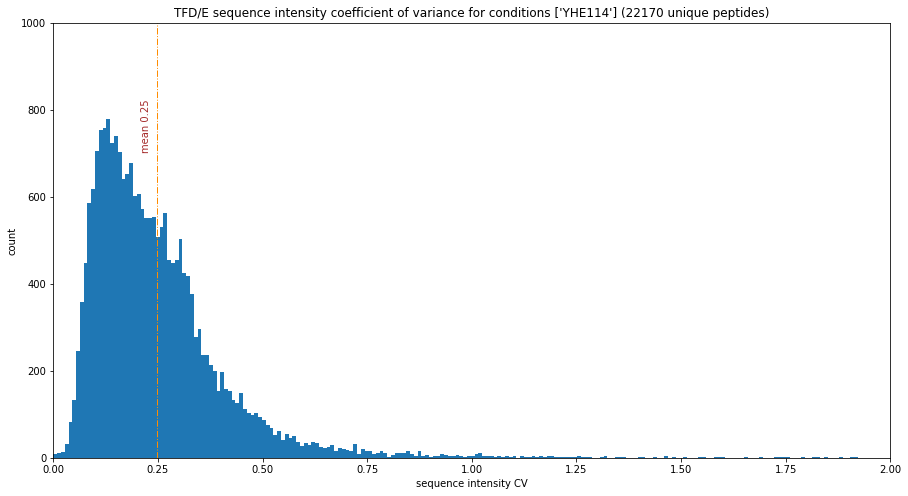

In [134]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
values = sequence_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
plt.title('TFD/E sequence intensity coefficient of variance for conditions {} ({} unique peptides)'.format(subset_groups,len(sequence_cv_df)))
plt.xlim((0,2))
plt.ylim((0,1000))

plt.show()

#### MQ analysis

In [135]:
# for each sequence, find the CV
sequence_cv_l = []
for group_name,group_df in mq_subset_df.groupby(['sequence','modifications','charge']):
    if len(group_df) >= 2:
        intensity_cv = np.std(group_df.intensity) / np.mean(group_df.intensity)
        sequence = ','.join([group_name[0],group_name[1],group_name[2].astype('str')])
        sequence_cv_l.append((sequence, intensity_cv))
mq_sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','intensity_cv'])

In [136]:
mq_sequence_cv_df.sample(n=3)

,sequence,intensity_cv
1068,"AQGVLFDCDGVLWNGER,Unmodified,2",0.206503
6459,"HYNGEAYEDDEHHPR,Unmodified,2",0.115834
7160,"IMNVIGEPIDER,Unmodified,2",0.129808


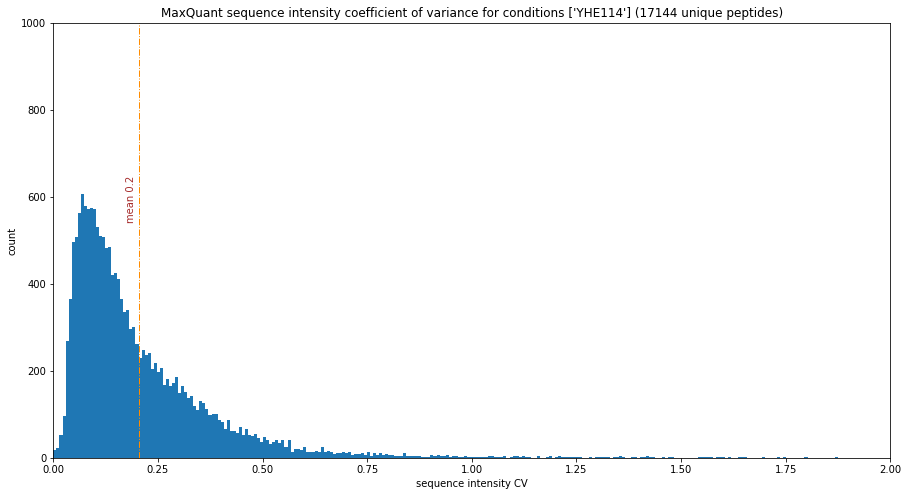

In [137]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
values = mq_sequence_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
plt.title('MaxQuant sequence intensity coefficient of variance for conditions {} ({} unique peptides)'.format(subset_groups, len(mq_sequence_cv_df)))
plt.xlim((0,2))
plt.ylim((0,1000))

plt.show()

#### Fragger analysis

In [138]:
# for each sequence, find the CV
sequence_cv_l = []
for group_name,group_df in fragger_subset_df.groupby(['PeptideSequence', 'PrecursorCharge']):
    if len(group_df) >= 2:
        intensity_cv = np.std(group_df.Intensity) / np.mean(group_df.Intensity)
        sequence = ','.join([group_name[0],group_name[1].astype('str')])
        sequence_cv_l.append((sequence, intensity_cv))
fragger_sequence_cv_df = pd.DataFrame(sequence_cv_l, columns=['sequence','intensity_cv'])

In [139]:
fragger_sequence_cv_df.sample(n=3)

,sequence,intensity_cv
14032,"STMTGSNMISNQEFER,2",0.082722
17959,"n[42.0106]MDSEVAALVIDNGSGMC[57.0215]K,2",0.227814
6328,"HDGSEPC[57.0215]VDVLFGDGHR,3",0.143949


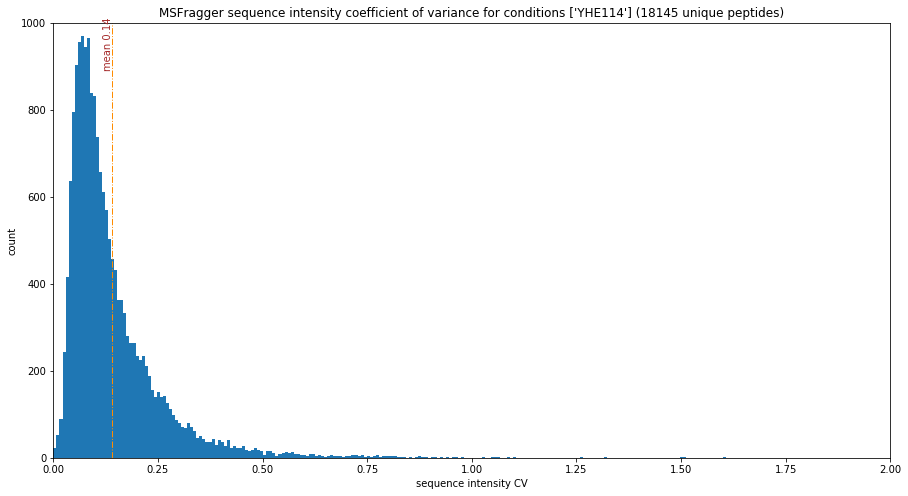

In [140]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 300
values = fragger_sequence_cv_df.intensity_cv
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('sequence intensity CV')
plt.ylabel('count')
plt.title('MSFragger sequence intensity coefficient of variance for conditions {} ({} unique peptides)'.format(subset_groups,len(fragger_sequence_cv_df)))
plt.xlim((0,2))
plt.ylim((0,1000))

plt.show()

## comparison of peptide intensity in different experiment conditions

In [141]:
# the experiment conditions to compare
groupA = 'YHE114'
groupA_number_of_runs = 10
groupB = 'YHE211'
groupB_number_of_runs = 10

#### TFD/E analysis

In [142]:
sequences_df.columns

Index(['sequence', 'charge', 'id_perc_q_value', 'protein', 'species',
       'short_run_name', 'group', 'intensity', 'identified_in_run'],
      dtype='object')

In [143]:
sequences_df.identified_in_run.sum()

266026

In [144]:
len(sequences_df[sequences_df.identified_in_run == True])

266026

In [196]:
# for each sequence and charge, if it was found in more than half the runs, 
# find the mean intensity in each group, then find the intensity ratio between groups
sequence_occurences_in_group = []
for group_name,group_df in sequences_df.groupby(['sequence','charge'], as_index=False):
    sequence_in_A_df = group_df[group_df.group == groupA]
    sequence_in_B_df = group_df[group_df.group == groupB]
    if (
            (sequence_in_A_df.identified_in_run.sum() > 0) and            # must have at least one ID in the group
            (sequence_in_B_df.identified_in_run.sum() > 0) and
            (len(sequence_in_A_df) >= int(groupA_number_of_runs / 2)) and # must have been extracted from more than half the runs in the group
            (len(sequence_in_B_df) >= int(groupB_number_of_runs / 2))
            ):
        intensity_A = sequence_in_A_df.intensity.mean()
        intensity_B = sequence_in_B_df.intensity.mean()
        species = group_df.iloc[0].species
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_group.append((sequence, charge, species, intensity_A, intensity_B))

In [197]:
sequence_occurences_in_group_df = pd.DataFrame(sequence_occurences_in_group, columns=['sequence','charge','species','intensity_A','intensity_B'])

In [198]:
sequence_occurences_in_group_df['intensity_ratio'] = sequence_occurences_in_group_df.intensity_B / sequence_occurences_in_group_df.intensity_A

In [199]:
sequence_occurences_in_group_df['intensity_ratio_log'] = np.log2(sequence_occurences_in_group_df['intensity_ratio'])

In [225]:
sequence_occurences_in_group_df[(np.log2(sequence_occurences_in_group_df.intensity_ratio) > -0.5) & (np.log2(sequence_occurences_in_group_df.intensity_A) > 12) & (sequence_occurences_in_group_df.species == 'E.COLI')].sample(n=5)

,sequence,charge,species,intensity_A,intensity_B,intensity_ratio,intensity_ratio_log
9082,STVGHDLNLDVCSK,2,E.COLI,5607.3,5756.600000,1.026626,0.037911
5810,LINDAYDSEYFATK,2,E.COLI,5194.7,4738.500000,0.912180,-0.132610
6131,LPGAVLHCFTGTR,2,E.COLI,6202.6,5929.400000,0.955954,-0.064987
5231,KLAEGLDALVM[15.9949]DVK,2,E.COLI,10926.6,9822.900000,0.898990,-0.153624
8132,Q[-17.0265]M[15.9949]LDAIIEERGDLAR,2,E.COLI,6416.1,5653.444444,0.881134,-0.182567


In [232]:
seq = 'LPGAVLHCFTGTR'
seq_charge = 2
df_A = sequences_df[(sequences_df.sequence == seq) & (sequences_df.group == groupA)]
df_B = sequences_df[(sequences_df.sequence == seq) & (sequences_df.group == groupB)]

In [233]:
df_A

,sequence,charge,id_perc_q_value,protein,species,short_run_name,group,intensity,identified_in_run
291063,LPGAVLHCFTGTR,2,0.000275,sp|P27859|TATD_ECOLI,E.COLI,YHE114_2,YHE114,6478,True
291064,LPGAVLHCFTGTR,2,0.000275,sp|P27859|TATD_ECOLI,E.COLI,YHE114_10,YHE114,6096,False
291065,LPGAVLHCFTGTR,2,0.000275,sp|P27859|TATD_ECOLI,E.COLI,YHE114_6,YHE114,5514,True
291066,LPGAVLHCFTGTR,2,0.000275,sp|P27859|TATD_ECOLI,E.COLI,YHE114_7,YHE114,6596,True
291067,LPGAVLHCFTGTR,2,0.000275,sp|P27859|TATD_ECOLI,E.COLI,YHE114_5,YHE114,6482,False
291068,LPGAVLHCFTGTR,2,0.000275,sp|P27859|TATD_ECOLI,E.COLI,YHE114_3,YHE114,6841,True
291069,LPGAVLHCFTGTR,2,0.000275,sp|P27859|TATD_ECOLI,E.COLI,YHE114_4,YHE114,5762,False
291070,LPGAVLHCFTGTR,2,0.000275,sp|P27859|TATD_ECOLI,E.COLI,YHE114_1,YHE114,5837,True
291071,LPGAVLHCFTGTR,2,0.000275,sp|P27859|TATD_ECOLI,E.COLI,YHE114_9,YHE114,6246,False
291072,LPGAVLHCFTGTR,2,0.000275,sp|P27859|TATD_ECOLI,E.COLI,YHE114_8,YHE114,6174,True


In [234]:
df_B

,sequence,charge,id_perc_q_value,protein,species,short_run_name,group,intensity,identified_in_run
291073,LPGAVLHCFTGTR,2,0.000275,sp|P27859|TATD_ECOLI,E.COLI,YHE211_6,YHE211,6084,True
291074,LPGAVLHCFTGTR,2,0.000275,sp|P27859|TATD_ECOLI,E.COLI,YHE211_10,YHE211,5164,False
291075,LPGAVLHCFTGTR,2,0.000275,sp|P27859|TATD_ECOLI,E.COLI,YHE211_8,YHE211,5986,False
291076,LPGAVLHCFTGTR,2,0.000275,sp|P27859|TATD_ECOLI,E.COLI,YHE211_1,YHE211,5917,False
291077,LPGAVLHCFTGTR,2,0.000275,sp|P27859|TATD_ECOLI,E.COLI,YHE211_5,YHE211,6148,True
291078,LPGAVLHCFTGTR,2,0.000275,sp|P27859|TATD_ECOLI,E.COLI,YHE211_9,YHE211,5951,False
291079,LPGAVLHCFTGTR,2,0.000275,sp|P27859|TATD_ECOLI,E.COLI,YHE211_7,YHE211,6067,True
291080,LPGAVLHCFTGTR,2,0.000275,sp|P27859|TATD_ECOLI,E.COLI,YHE211_3,YHE211,5823,True
291081,LPGAVLHCFTGTR,2,0.000275,sp|P27859|TATD_ECOLI,E.COLI,YHE211_2,YHE211,6484,True
291082,LPGAVLHCFTGTR,2,0.000275,sp|P27859|TATD_ECOLI,E.COLI,YHE211_4,YHE211,5670,True


In [235]:
df_A.intensity.mean(), df_A.intensity.std()

(6202.6, 412.6142131445412)

In [236]:
df_B.intensity.mean(), df_B.intensity.std()

(5929.4, 344.23383525349936)

In [237]:
sequence_occurences_in_group_df[(sequence_occurences_in_group_df.sequence == seq) & (sequence_occurences_in_group_df.charge == seq_charge)]

,sequence,charge,species,intensity_A,intensity_B,intensity_ratio,intensity_ratio_log
6131,LPGAVLHCFTGTR,2,E.COLI,6202.6,5929.4,0.955954,-0.064987


In [207]:
human_df = sequence_occurences_in_group_df[sequence_occurences_in_group_df.species == 'HUMAN']
yeast_df = sequence_occurences_in_group_df[sequence_occurences_in_group_df.species == 'YEAST']
ecoli_df = sequence_occurences_in_group_df[sequence_occurences_in_group_df.species == 'E.COLI']

In [208]:
max_tfde = max(np.log2(sequence_occurences_in_group_df.intensity_A).max(), np.log2(sequence_occurences_in_group_df.intensity_B).max())
min_tfde = min(np.log2(sequence_occurences_in_group_df.intensity_A).min(), np.log2(sequence_occurences_in_group_df.intensity_B).min())
max_tfde, min_tfde

(15.6005024186517, 6.894817763307944)

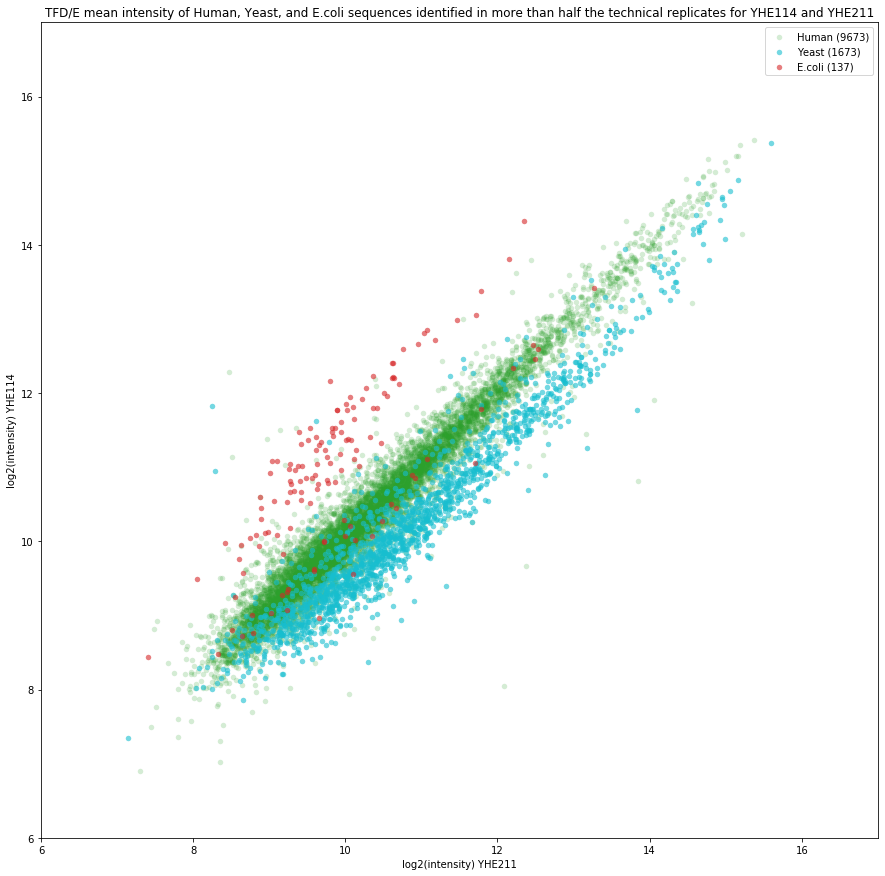

In [224]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'TFD/E mean intensity of Human, Yeast, and E.coli sequences identified in more than half the technical replicates for {} and {}'.format(groupA, groupB)
plt.title(title)

ax.scatter(np.log2(human_df.intensity_B), np.log2(human_df.intensity_A), marker='o', color='tab:green', lw=0, s=30, alpha=0.2, label="Human ({})".format(len(human_df)))
ax.scatter(np.log2(yeast_df.intensity_B), np.log2(yeast_df.intensity_A), marker='o', color='tab:cyan', lw=0, s=30, alpha=0.6, label="Yeast ({})".format(len(yeast_df)))
ax.scatter(np.log2(ecoli_df.intensity_B), np.log2(ecoli_df.intensity_A), marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli ({})".format(len(ecoli_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) {}'.format(groupB))
plt.ylabel('log2(intensity) {}'.format(groupA))

plt.xlim((6,17))
plt.ylim((6,17))

plt.show()

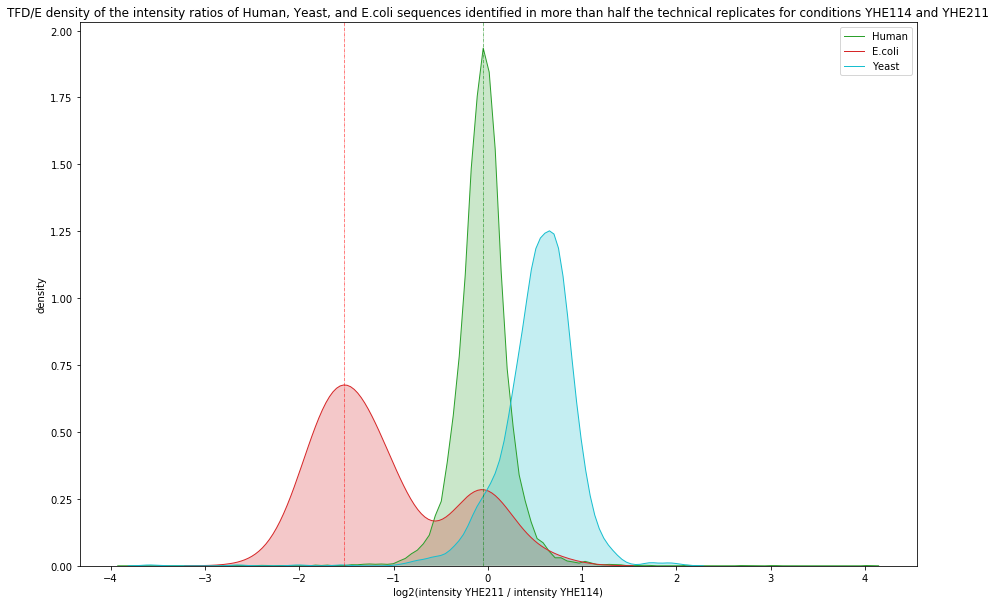

In [210]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'TFD/E density of the intensity ratios of Human, Yeast, and E.coli sequences identified in more than half the technical replicates for conditions {} and {}'.format(groupA, groupB)
plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(np.log2(human_df['intensity_ratio']), hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(np.log2(ecoli_df['intensity_ratio']), hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'E.coli')
_ = sns.distplot(np.log2(yeast_df['intensity_ratio']), hist = False, color='tab:cyan', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Yeast')

x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

x = ax.lines[1].get_xdata()
y = ax.lines[1].get_ydata()
plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

_ = ax.set(xlabel='log2(intensity {} / intensity {})'.format(groupB, groupA), ylabel='density')


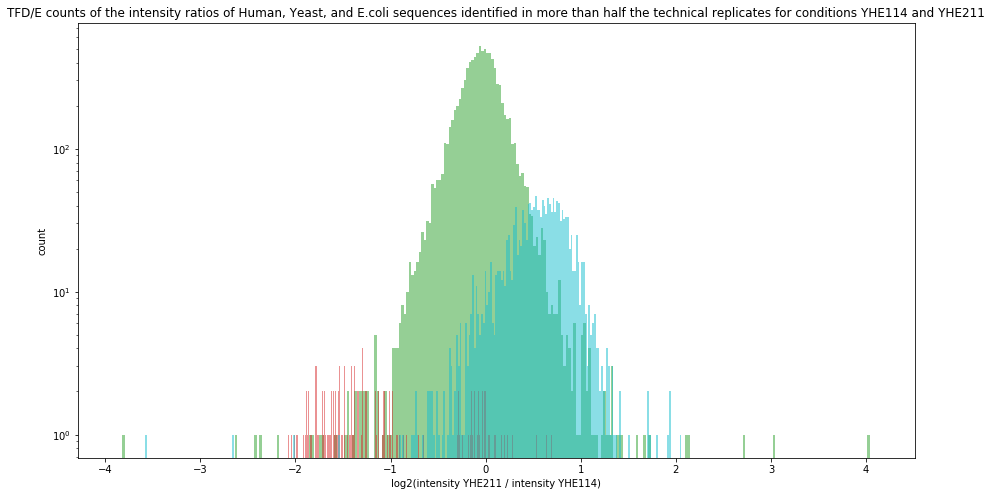

In [211]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

title = 'TFD/E counts of the intensity ratios of Human, Yeast, and E.coli sequences identified in more than half the technical replicates for conditions {} and {}'.format(groupA, groupB)
plt.margins(0.06)
plt.title(title)

bins = 300
y, x, _ = ax1.hist(np.log2(human_df['intensity_ratio']), bins=bins, color='tab:green', alpha=0.5)
y, x, _ = ax1.hist(np.log2(ecoli_df['intensity_ratio']), bins=bins, color='tab:red', alpha=0.5)
y, x, _ = ax1.hist(np.log2(yeast_df['intensity_ratio']), bins=bins, color='tab:cyan', alpha=0.5)

plt.xlabel('log2(intensity {} / intensity {})'.format(groupB, groupA))
plt.ylabel('count')
# plt.xlim((0,2))
# plt.ylim((0,60))
plt.yscale('log', basey=10, nonposy='clip')

plt.show()

#### MQ analysis

In [161]:
mq_sequences_df.columns

Index(['sequence', 'modifications', 'charge', 'species', 'short_run_name',
       'group', 'identified_in_file', 'score', 'intensity'],
      dtype='object')

In [162]:
# for each sequence and charge, if it was found in more than half the runs, 
# find the mean intensity in each group, then find the intensity ratio between groups
sequence_occurences_in_group = []
for group_name,group_df in mq_sequences_df.groupby(['sequence','modifications','charge'], as_index=False):
    sequence_in_A_df = group_df[group_df.group == groupA]
    sequence_in_B_df = group_df[group_df.group == groupB]
    if (len(sequence_in_A_df) >= int(groupA_number_of_runs / 2)) and (len(sequence_in_B_df) >= int(groupB_number_of_runs / 2)):
        average_intensity_in_A = sequence_in_A_df.intensity.mean()
        average_intensity_in_B = sequence_in_B_df.intensity.mean()
        species = group_df.iloc[0].species
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_group.append((sequence, charge, species, average_intensity_in_A, average_intensity_in_B))

In [163]:
mq_sequence_occurences_in_group_df = pd.DataFrame(sequence_occurences_in_group, columns=['sequence','charge','species','intensity_A','intensity_B'])

In [164]:
mq_sequence_occurences_in_group_df['intensity_ratio'] = mq_sequence_occurences_in_group_df.intensity_B / mq_sequence_occurences_in_group_df.intensity_A

In [165]:
human_df = mq_sequence_occurences_in_group_df[mq_sequence_occurences_in_group_df.species == 'HUMAN']
yeast_df = mq_sequence_occurences_in_group_df[mq_sequence_occurences_in_group_df.species == 'YEAST']
ecoli_df = mq_sequence_occurences_in_group_df[mq_sequence_occurences_in_group_df.species == 'E.COLI']

In [166]:
max_mq = max(np.log2(mq_sequence_occurences_in_group_df.intensity_A).max(), np.log2(mq_sequence_occurences_in_group_df.intensity_B).max())
min_mq = min(np.log2(mq_sequence_occurences_in_group_df.intensity_A).min(), np.log2(mq_sequence_occurences_in_group_df.intensity_B).min())
max_mq, min_mq

(23.926745521680008, 10.89240367575133)

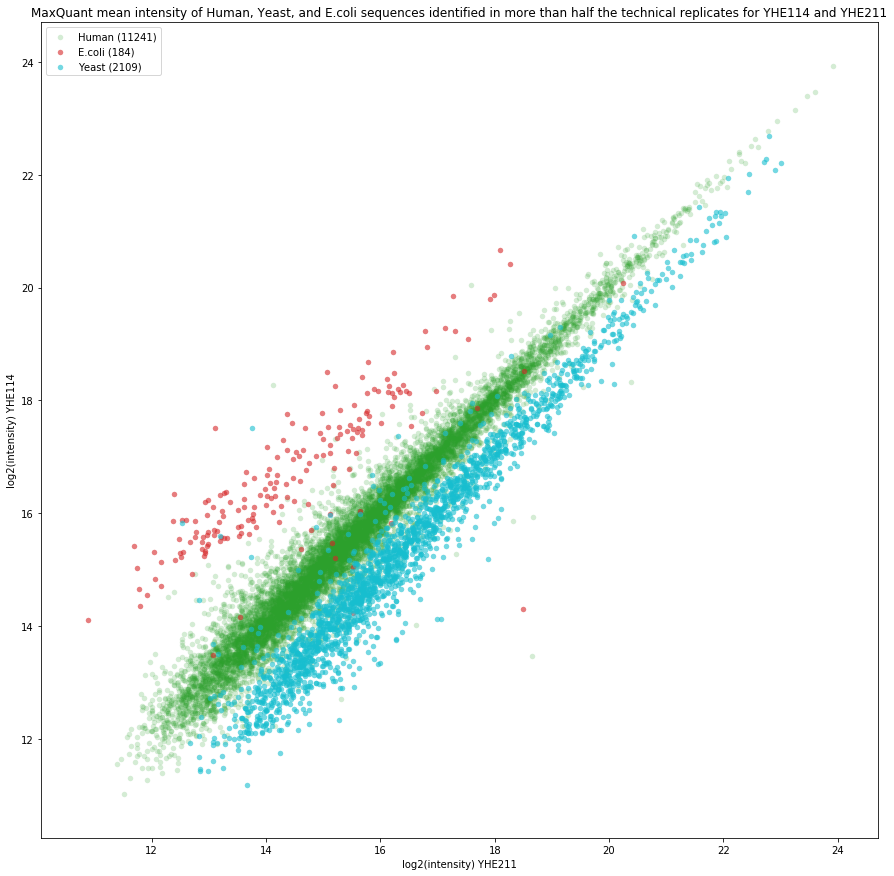

In [167]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'MaxQuant mean intensity of Human, Yeast, and E.coli sequences identified in more than half the technical replicates for {} and {}'.format(groupA, groupB)
plt.title(title)

ax.scatter(np.log2(human_df.intensity_B), np.log2(human_df.intensity_A), marker='o', color='tab:green', lw=0, s=30, alpha=0.2, label="Human ({})".format(len(human_df)))
ax.scatter(np.log2(ecoli_df.intensity_B), np.log2(ecoli_df.intensity_A), marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli ({})".format(len(ecoli_df)))
ax.scatter(np.log2(yeast_df.intensity_B), np.log2(yeast_df.intensity_A), marker='o', color='tab:cyan', lw=0, s=30, alpha=0.6, label="Yeast ({})".format(len(yeast_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) {}'.format(groupB))
plt.ylabel('log2(intensity) {}'.format(groupA))

# plt.xlim((7,24))
# plt.ylim((7,24))

plt.show()

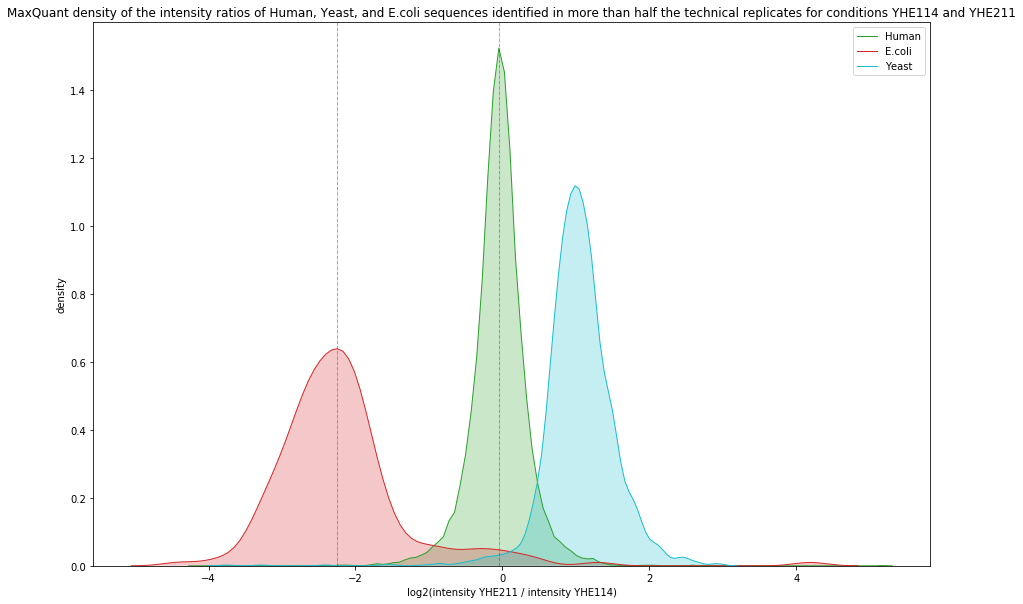

In [168]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'MaxQuant density of the intensity ratios of Human, Yeast, and E.coli sequences identified in more than half the technical replicates for conditions {} and {}'.format(groupA, groupB)
plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(np.log2(human_df['intensity_ratio']), hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(np.log2(ecoli_df['intensity_ratio']), hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'E.coli')
_ = sns.distplot(np.log2(yeast_df['intensity_ratio']), hist = False, color='tab:cyan', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Yeast')

x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

x = ax.lines[1].get_xdata()
y = ax.lines[1].get_ydata()
plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

_ = ax.set(xlabel='log2(intensity {} / intensity {})'.format(groupB, groupA), ylabel='density')


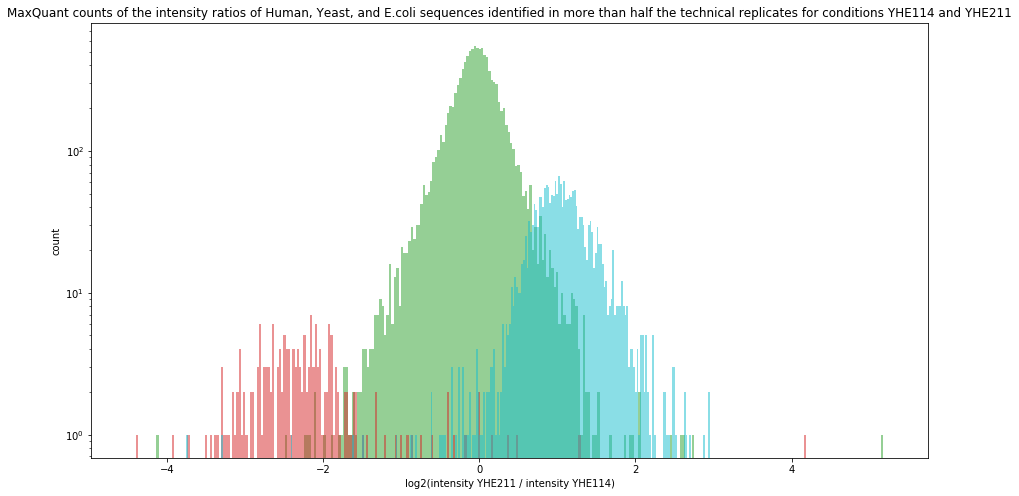

In [169]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

title = 'MaxQuant counts of the intensity ratios of Human, Yeast, and E.coli sequences identified in more than half the technical replicates for conditions {} and {}'.format(groupA, groupB)
plt.margins(0.06)
plt.title(title)

bins = 300
y, x, _ = ax1.hist(np.log2(human_df['intensity_ratio']), bins=bins, color='tab:green', alpha=0.5)
y, x, _ = ax1.hist(np.log2(ecoli_df['intensity_ratio']), bins=bins, color='tab:red', alpha=0.5)
y, x, _ = ax1.hist(np.log2(yeast_df['intensity_ratio']), bins=bins, color='tab:cyan', alpha=0.5)

plt.xlabel('log2(intensity {} / intensity {})'.format(groupB, groupA))
plt.ylabel('count')
# plt.xlim((0,2))
# plt.ylim((0,60))
plt.yscale('log', basey=10, nonposy='clip')

plt.show()

#### Fragger analysis

In [170]:
fragger_sequences_df.columns

Index(['ProteinName', 'PeptideSequence', 'PrecursorCharge', 'FragmentIon',
       'ProductCharge', 'IsotopeLabelType', 'Condition', 'BioReplicate', 'Run',
       'Intensity', 'short_run_name', 'species'],
      dtype='object')

In [171]:
# for each sequence and charge, if it was found in more than half the runs, 
# find the mean intensity in each group, then find the intensity ratio between groups
sequence_occurences_in_group = []
for group_name,group_df in fragger_sequences_df.groupby(['PeptideSequence','PrecursorCharge'], as_index=False):
    sequence_in_A_df = group_df[group_df.Condition == groupA]
    sequence_in_B_df = group_df[group_df.Condition == groupB]
    if (len(sequence_in_A_df) >= int(groupA_number_of_runs / 2)) and (len(sequence_in_B_df) >= int(groupB_number_of_runs / 2)):
        average_intensity_in_A = sequence_in_A_df.Intensity.mean()
        average_intensity_in_B = sequence_in_B_df.Intensity.mean()
        species = group_df.iloc[0].species
        sequence = group_name[0]
        charge = group_name[1]
        sequence_occurences_in_group.append((sequence, charge, species, average_intensity_in_A, average_intensity_in_B))

In [172]:
fragger_sequence_occurences_in_group_df = pd.DataFrame(sequence_occurences_in_group, columns=['sequence','charge','species','intensity_A','intensity_B'])

In [173]:
fragger_sequence_occurences_in_group_df['intensity_ratio'] = fragger_sequence_occurences_in_group_df.intensity_B / fragger_sequence_occurences_in_group_df.intensity_A

In [174]:
human_df = fragger_sequence_occurences_in_group_df[fragger_sequence_occurences_in_group_df.species == 'HUMAN']
yeast_df = fragger_sequence_occurences_in_group_df[fragger_sequence_occurences_in_group_df.species == 'YEAST']
ecoli_df = fragger_sequence_occurences_in_group_df[fragger_sequence_occurences_in_group_df.species == 'E.COLI']

In [175]:
max_fragger = max(np.log2(fragger_sequence_occurences_in_group_df.intensity_A).max(), np.log2(fragger_sequence_occurences_in_group_df.intensity_B).max())
min_fragger = min(np.log2(fragger_sequence_occurences_in_group_df.intensity_A).min(), np.log2(fragger_sequence_occurences_in_group_df.intensity_B).min())
max_fragger, min_fragger

(21.560112164042202, 9.333162942768416)

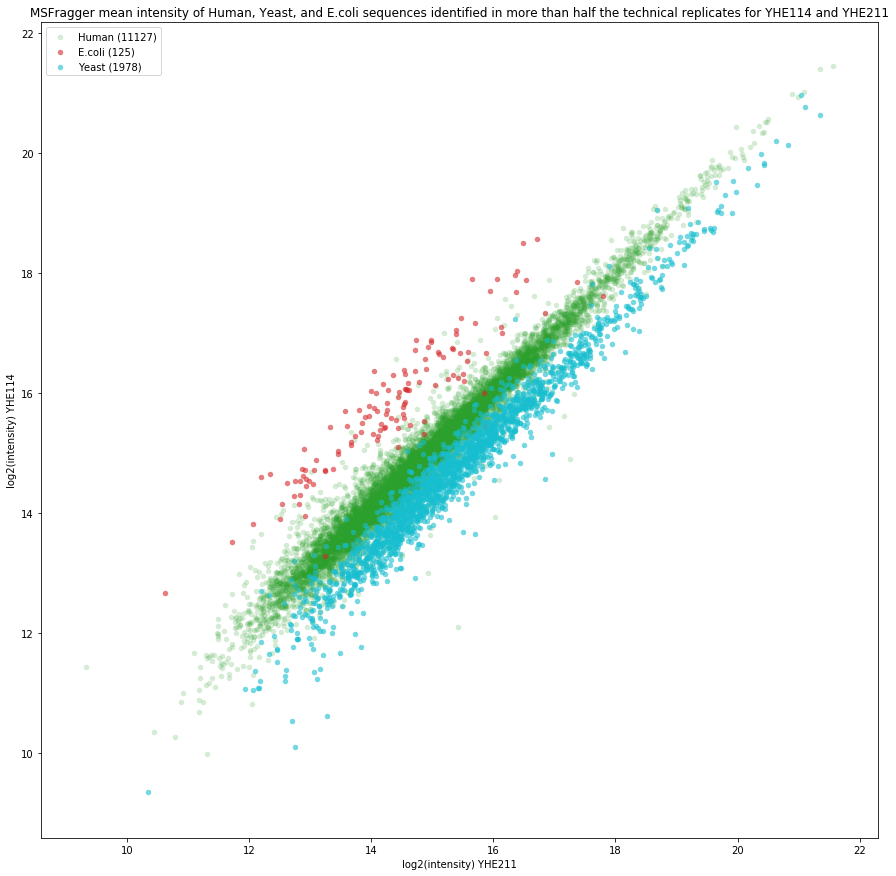

In [176]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)
plt.margins(0.06)

title = 'MSFragger mean intensity of Human, Yeast, and E.coli sequences identified in more than half the technical replicates for {} and {}'.format(groupA, groupB)
plt.title(title)

ax.scatter(np.log2(human_df.intensity_B), np.log2(human_df.intensity_A), marker='o', color='tab:green', lw=0, s=30, alpha=0.2, label="Human ({})".format(len(human_df)))
ax.scatter(np.log2(ecoli_df.intensity_B), np.log2(ecoli_df.intensity_A), marker='o', color='tab:red', lw=0, s=30, alpha=0.6, label="E.coli ({})".format(len(ecoli_df)))
ax.scatter(np.log2(yeast_df.intensity_B), np.log2(yeast_df.intensity_A), marker='o', color='tab:cyan', lw=0, s=30, alpha=0.6, label="Yeast ({})".format(len(yeast_df)))

plt.legend(loc='best')
plt.xlabel('log2(intensity) {}'.format(groupB))
plt.ylabel('log2(intensity) {}'.format(groupA))

# plt.xlim((7,24))
# plt.ylim((7,24))

plt.show()

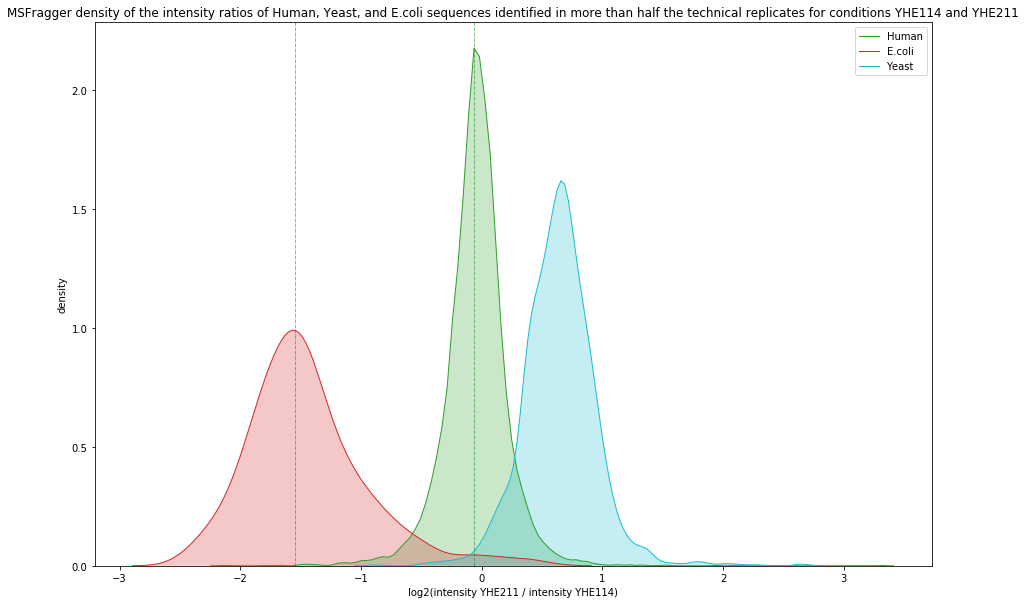

In [177]:
import seaborn as sns
plt.figure(figsize=(15, 10))

title = 'MSFragger density of the intensity ratios of Human, Yeast, and E.coli sequences identified in more than half the technical replicates for conditions {} and {}'.format(groupA, groupB)
plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(np.log2(human_df['intensity_ratio']), hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Human')
_ = sns.distplot(np.log2(ecoli_df['intensity_ratio']), hist = False, color='tab:red', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'E.coli')
_ = sns.distplot(np.log2(yeast_df['intensity_ratio']), hist = False, color='tab:cyan', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Yeast')

x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
plt.axvline(x[np.argmax(y)], color='green', lw=0.5, ls='-.')

x = ax.lines[1].get_xdata()
y = ax.lines[1].get_ydata()
plt.axvline(x[np.argmax(y)], color='red', lw=0.5, ls='-.')

_ = ax.set(xlabel='log2(intensity {} / intensity {})'.format(groupB, groupA), ylabel='density')


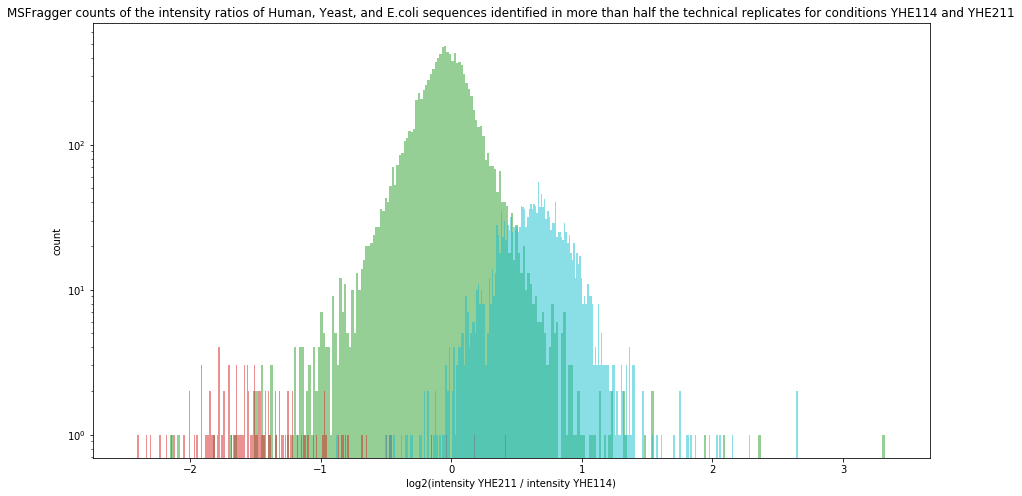

In [178]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

title = 'MSFragger counts of the intensity ratios of Human, Yeast, and E.coli sequences identified in more than half the technical replicates for conditions {} and {}'.format(groupA, groupB)
plt.margins(0.06)
plt.title(title)

bins = 300
y, x, _ = ax1.hist(np.log2(human_df['intensity_ratio']), bins=bins, color='tab:green', alpha=0.5)
y, x, _ = ax1.hist(np.log2(ecoli_df['intensity_ratio']), bins=bins, color='tab:red', alpha=0.5)
y, x, _ = ax1.hist(np.log2(yeast_df['intensity_ratio']), bins=bins, color='tab:cyan', alpha=0.5)

plt.xlabel('log2(intensity {} / intensity {})'.format(groupB, groupA))
plt.ylabel('count')
# plt.xlim((0,2))
# plt.ylim((0,60))
plt.yscale('log', basey=10, nonposy='clip')

plt.show()

In [179]:
max(max_tfde, max_mq, max_fragger), min(min_tfde, min_mq, min_fragger)

(23.926745521680008, 7.018200178813226)